In [1]:
# Импорт необходимых библиотек
import numpy as np  
import pandas as pd  
import datetime
from datetime import datetime  
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import io
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Загружаю датасет для предобработки:
def load_csv_from_zip(zip_path, csv_filename, encoding='utf_32', **kwargs):
    with zipfile.ZipFile(zip_path) as z:
        with z.open(csv_filename) as f:
            return pd.read_csv(f, encoding=encoding, **kwargs)
dataprep = load_csv_from_zip('data_bzk_pension_202201_202403_for_preprocessing2.zip', 'data_bzk_pension_202201_202403_for_preprocessing.csv', 
encoding='utf_32', dtype = {'PROCESS_REF': str, 'IIN_BIN': str, 'CONTRACT_NUMBER':str, 'PUBLIC_ID':str, 'DOC_NUMBER':str, 
                           'OCRM_SOURCE_ID':str, 'COLVIR_SOURCE_ID':str, 'documents_document_number':str}, 
parse_dates=['OPEN_DATE','ISSUE_DATE', 'HALYK_REG_DATE', 'LAST_DEPO_OPEN_DATE', 'FIRST_DEPO_OPEN_DATE', 'LAST_DEPO_REPLENISH_DATE', 
             'LAST_DEPO_WITHDRAWAL_DATE', 'LAST_LOAN_OPEN_DATE', 'FIRST_LOAN_OPEN_DATE', 'FIRST_PROUCT_DATE_CURRENT_ACCOUNT', 
             'FIRST_PROUCT_DATE_CREDIT_CARD', 'FIRST_PROUCT_DATE_DEBIT_CARD', 'LAST_AUTORIZATION_DATE_HB', 'FIRST_PROUCT_DATE',
             'DOC_EXPIRY_DATE', 'OCRM_REG_DATE', 'documents_document_beginDate','documents_document_birthDate', 
             'GtsvpServiceResponseData_Request_documentIssueDate', 'regAddress_region_changeDate', 'birthPlace_region_changeDate',
             'ColvirDepositAccount_Todate',	'PoVClient_ActualDate','InternalDelinquencyAccounts_Table_endDate',
             'ColvirDepositAccount_Fromdate', 'process_create','documents_document_iIvalidityDate','DateProcessStart',
             'InternalDelinquencyAccounts_Table_fromDate', 'ProcessStartTimeParametrSet', 'KINO_REG_DATE',
             'ColvirDepositAccount_Birthdate', 'PoVContactPhone_ActualDate','documents_document_endDate', 
             'ColvirDepositAccount_FirstFromdate'])

In [3]:
#Просмотр размера датасета
dataprep.shape

(224663, 1152)

In [4]:
#Функция конвертирования из числового формата в стринговый формат данных:
def convert_columns_to_str(df, columns):
    df = df.copy()
    for col in columns:
        if col in df.columns:
            df[col] = df[col].astype(str)
    return df
#Функция конвертирования переменных в числовой формат данных
def convert_columns_to_numeric(df, columns):
    df = df.copy()
    for col in columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

In [5]:
#Применение функции конвертирования из числового формата в стринговый формат данных:
columns_to_convert = ['FMGROUP', 'PKB_RESIDENT_FL', 'PKB_HEAD_REP_TYPE', 'pkb_resident_fl', 'CategoryParametrSet', 'Branch TypeParametrSet', 'CBIsCurDelayLarger5kParametrSet', 
'ClientCategoryParametrSet', 'HBIsRestrParametrSet', 'IsApplFormActualParametrSet', 'FinHasCredHistParametrSet', 'ASPFlagParametrSet', 'HBHasCreditHistParametrSet', 'IgnoreDiscountParametrSet', 
'CtrlGrpParametrSet', 'IsCPPPaysInLastMonthParametrSet', 'IsCPPPaysInLast2MonthsParametrSet', 'Categorydssb_ocds_paramset', 'CtrlGrpdssb_ocds_paramset', 'IsRefinancedssb_ocds_paramset', 
'ASPFlagdssb_ocds_paramset', 'FinHasCredHistdssb_ocds_paramset', 'ClientCategorydssb_ocds_paramset', 'VerifiedIncomedssb_ocds_paramset', 'IsCPPPaysInLast2Monthsdssb_ocds_paramset', 'verifiedincomedmparse2']
dataprep = convert_columns_to_str(dataprep, columns_to_convert)

In [6]:
#Функция заполнения пустых значений в переменных со стринговым форматом:
def fillna_none_except_list(df, exclude_columns):
    df = df.copy()
    for col in df.select_dtypes(include=['object']).columns:
        if col not in exclude_columns:
            df[col] = df[col].fillna('None')
    return df	
dataprep = fillna_none_except_list(dataprep, exclude_columns=['PROCESS_REF', 'IIN_BIN', 'CONTRACT_NUMBER', 'STATUS_NAME'])

In [7]:
#Запись переменных с уникальными значениями меньше или равно двух в отдельный лист
vc_2_cols = [col for col in dataprep.columns if dataprep[col].nunique(dropna=False) <= 2]

In [8]:
#Удаляю переменные с уникальными значениями меньше или равно двух
drop_cols = ['AmountInColvirsLineParametrSet', 'CBIsCurDelayLarger5kParametrSet', 'IsApplFormActualParametrSet', 'FinHasCredHistParametrSet', 'LowRODParametrSet', 'HBHasCreditHistParametrSet', 'IgnoreDiscountParametrSet', 'CtrlGrpParametrSet', 'GtsvpServiceResponseData_Request_EmpLogin', 'CBHistDelayMaxAmountdssb_ocds_paramset', 'CBoverdues_90_2Ydssb_ocds_paramset', 'VerifiedIncomedssb_ocds_paramset', 'verifiedincomedmparse2', 'cred_dpd_cnt_avto', 'cred_dpd_cnt_30d_avto', 'cred_dpd_cnt_90d_avto', 'cred_insur_cnt_avto', 'cred_repaid_early_sum_in360d_avto', 'pkb_bvu_nominal_rate_pledge_bzk_0', 'pkb_bvu_nominal_rate_pledge_cc_0', 'pkb_bvu_nominal_rate_pledge_lgot_avto', 'pkb_criminal_status', 'pkb_missing_status', 'cred_dpd_cnt_30d_bnpl', 'cred_dpd_cnt_90d_bnpl', 'cred_insur_cnt_bnpl', 'cred_dpd_cnt_90d_bzk', 'cred_dpd_sum_ipoteka', 'cred_dpd_sum_10d_ipoteka','cred_dpd_cnt_30d_ipoteka','cred_dpd_cnt_90d_ipoteka','cred_dpd_annuity_sum_ipoteka','cred_dpd_annuity_sum_10d_ipoteka','cred_insur_cnt_ipoteka','cred_req_ipoteka_cnt_90d_issued','cred_req_ipoteka_cnt_180d_issued','depo_in_euro_30d','depo_in_euro_90d','depo_in_euro_360d','pkb_bvu_loan_cnt_lender_alhilal',
'pkb_bvu_monthly_payment_lender_vtb', 'pkb_bvu_od_pledge_lgot_avto','pkb_bvu_max_delay_day_cnt_2y_pledge_7_20_25','pkb_bvu_max_delay_day_cnt_2y_pledge_lgot_avto','pkb_bvu_max_delay_amount_2y_pledge_7_20_25','pkb_bvu_max_delay_amount_2y_pledge_lgot_avto', 'pkb_bvu_monthly_payment_lender_alhilal', 'CBoverdues_90ParametrSet', 'pkb_bvu_credit_sum_lender_alhilal','pkb_bvu_od_lender_alhilal','pkb_bvu_max_delay_day_cnt_2y_lender_vtb','pkb_bvu_max_delay_day_cnt_2y_lender_alhilal','pkb_bvu_max_delay_day_cnt_2y_lender_shinkhan','pkb_bvu_max_delay_amount_2y_lender_vtb','pkb_bvu_max_delay_amount_2y_lender_alhilal','pkb_bvu_max_delay_amount_2y_lender_shinkhan','pkb_bvu_nominal_rate_lender_alhilal','pkb_bvu_loan_cnt_pledge_lgot_avto','pkb_bvu_monthly_payment_pledge_lgot_avto','pkb_bvu_credit_sum_pledge_lgot_avto']
dataprep.drop(drop_cols, axis = 1, inplace = True, errors = 'ignore')

In [9]:
#Редактирование ошибочных значений в переменной CITIZENSHIP:
dataprep['CITIZENSHIP'] = dataprep['CITIZENSHIP'].replace('RUS', 'RUSSIAN FEDERATION')
dataprep['CITIZENSHIP'] = dataprep['CITIZENSHIP'].replace('KGZ', 'KYRGYZSTAN')
dataprep['CITIZENSHIP'] = dataprep['CITIZENSHIP'].replace('UZB', 'UZBEKISTAN')
dataprep['CITIZENSHIP'] = dataprep['CITIZENSHIP'].replace('KAZAKHSTAN (19)', 'КАЗАХСТАН')
dataprep['CITIZENSHIP'] = dataprep['CITIZENSHIP'].replace('КАЗАХСТАН', 'KAZAKHSTAN')
dataprep['CITIZENSHIP'] = dataprep['CITIZENSHIP'].replace('UZB', 'UZBEKISTAN')
dataprep['CITIZENSHIP'] = dataprep['CITIZENSHIP'].replace('GEO', 'None')
#Генерализация значений в переменной EDUCATION:
dataprep['EDUCATION'] = dataprep['EDUCATION'].replace('Магистратура', 'Высшее')
dataprep['EDUCATION'] = dataprep['EDUCATION'].replace('Докторантура/аспирантура', 'Высшее')
dataprep['EDUCATION'] = dataprep['EDUCATION'].replace('Основное среднее', 'Общее среднее')
dataprep['EDUCATION'] = dataprep['EDUCATION'].replace('Начальное профессиональное', 'Среднее специальное')
dataprep['EDUCATION'] = dataprep['EDUCATION'].replace('Начальное общее', 'Общее среднее')

In [10]:
drop_cols = [# номера счетов в Colvir:
'InternalDelinquencyAccounts_Table_stat', 
# документе:
'DOC_NUMBER',  'documents_document_number',
# id клиента:   
'UserID', 'PUBLIC_ID', 'OCRM_SOURCE_ID', 'COLVIR_SOURCE_ID',
# id заявки:
'id', 'ProcessID', 'order_id', 'process_ref', 'PROCESS_REF',
# статусе контракта:
'STATUS_NAME']
dataprep.drop(drop_cols, axis = 1, inplace = True, errors = 'ignore')

In [11]:
#удаляю т.к. есть аналогичная переменная на русском языке, переменная с меньшим процентом пустых значений
drop_cols = ['documents_document_type_nameKz', 'birthPlace_region_nameKz', 'birthPlace_district_nameKz', 'birthPlace_country_nameKz', 'regAddress_region_nameKz', 'regAddress_district_nameKz', 'citizenship_nameKz', 'documents_document_status_nameKz', 
'nationality_nameKz', 'CBCreditHistoryFromServdssb_ocds_paramset', 'HBCreditHistorydssb_ocds_paramset', 'HBCreditHistoryFromServdssb_ocds_paramset', 'FinalCreditHistorydssb_ocds_paramset', 'CtrlGrpdssb_ocds_paramset', 'IsRefinancedssb_ocds_paramset', 'ASPFlagdssb_ocds_paramset', 'Categorydssb_ocds_paramset', 'MaritalStatusdssb_ocds_paramset', 'CBCreditHistorydssb_ocds_paramset', 'ClientCategorydssb_ocds_paramset', 'IsCPPPaysInLast2Monthsdssb_ocds_paramset', 'bindssb_ocds_paramset', 'cbcredithistorydmparse2', 'hbcredithistorydmparse2', 'finalcredithistorydmparse2',]
dataprep.drop(drop_cols, axis = 1, inplace = True, errors = 'ignore')

In [12]:
#удаляю переменные, сложно внедрить в кредитный конвейер из-за уникальных значений > 5000
drop_cols = ['regAddress_city', 'birthPlace_city', 'birthPlace_foreignData_RegionName', 'InternalDelinquencyAccounts_Table_deaCode']
dataprep.drop(drop_cols, axis = 1, inplace = True, errors = 'ignore')

In [13]:
#удаляю т.к. непонятные значения
drop_cols = ['Branch TypeParametrSet', 'InternalDelinquencyAccounts_Table_prdName', 'InternalDelinquencyAccounts_Table_dclName', 'ClientCategoryParametrSet', 'PKB_HEAD_REP_TYPE', 
'WarningCodedssb_ocds_paramset', 'pkb_resident_fl', 'FinHasCredHistdssb_ocds_paramset', 'SalaryByWordParametrSet']
dataprep.drop(drop_cols, axis = 1, inplace = True, errors = 'ignore')

In [14]:
#редактирование переменных maritalstatusdmparse2, educationtypedmparse2, positiontypedmparse2, housingtypedmparse2
dataprep['maritalstatusdmparse2'] = dataprep['maritalstatusdmparse2'].replace('ГОРОД АЛМАТЫ', 'None')
dataprep['maritalstatusdmparse2'] = dataprep['maritalstatusdmparse2'].replace('ГОРОД ШЫМКЕНТ', 'None')
dataprep['educationtypedmparse2'] = dataprep['educationtypedmparse2'].replace('ГОРОД АЛМАТЫ', 'None')
dataprep['educationtypedmparse2'] = dataprep['educationtypedmparse2'].replace('ГОРОД ШЫМКЕНТ', 'None')
dataprep['positiontypedmparse2'] = dataprep['positiontypedmparse2'].replace('ГОРОД АЛМАТЫ', 'None')
dataprep['positiontypedmparse2'] = dataprep['positiontypedmparse2'].replace('ГОРОД ШЫМКЕНТ', 'None')
dataprep['positiontypedmparse2'] = dataprep['positiontypedmparse2'].replace('САМОЗАНЯТЫЙ/ИП', 'ИП')
dataprep['housingtypedmparse2'] = dataprep['housingtypedmparse2'].replace('ГОРОД АЛМАТЫ', 'None')
dataprep['housingtypedmparse2'] = dataprep['housingtypedmparse2'].replace('ГОРОД ШЫМКЕНТ', 'None')

In [15]:
#создание переменной datediff_contropendate_documentbegindate - разницу между открытием контракта и начала даты документа
dataprep['datediff_contropendate_documentbegindate'] = (dataprep['OPEN_DATE'] - dataprep['documents_document_beginDate']).dt.days
#создание переменной datediff_contropendate_GtsvpServiceResponseData_Request_documentIssueDate - разницу между открытием контракта 
#и начала даты документа по ГЦВП
dataprep['datediff_contropendate_GtsvpServiceResponseData_Request_documentIssueDate'] = (dataprep['OPEN_DATE'] - dataprep['GtsvpServiceResponseData_Request_documentIssueDate']).dt.days
#создание переменной datediff_contropendate_regAddress_region_changeDate - разницу между открытием контракта и изменением адреса регистрации
dataprep['datediff_contropendate_regAddress_region_changeDate'] = (dataprep['OPEN_DATE'] - dataprep['regAddress_region_changeDate']).dt.days
#создание переменной datediff_contropendate_birthPlace_region_changeDate - разницу между открытием контракта и изменением адреса рождения
dataprep['datediff_contropendate_birthPlace_region_changeDate'] = (dataprep['OPEN_DATE'] - dataprep['birthPlace_region_changeDate']).dt.days
#создание переменной datediff_contropendate_ColvirDepositAccount_Fromdate - разницу между открытием контракта и датой открытием депозита в ХБ
dataprep['datediff_contropendate_ColvirDepositAccount_Fromdate'] = (dataprep['OPEN_DATE'] - dataprep['ColvirDepositAccount_Fromdate']).dt.days
#создание переменной datediff_contropendate_documents_document_iIvalidityDate - разницу между открытием контракта и датой валидности документа
dataprep['datediff_contropendate_documents_document_iIvalidityDate'] = (dataprep['documents_document_iIvalidityDate'] - dataprep['OPEN_DATE']).dt.days
#создание переменной datediff_contropendate_documents_document_endDate - разницу между открытием контракта и датой валидности документа
dataprep['datediff_contropendate_documents_document_endDate'] = (dataprep['documents_document_endDate'] - dataprep['OPEN_DATE']).dt.days

In [16]:
#редактирование ошибочных значений в переменной LAST_EVENT_COUNTRY, SALARY_CATEGORY_BY_MODEL, regAddress_district_nameRu, birthPlace_district_nameRu, birthPlace_country_nameRu, 
#regaddressnamerudmparse2
dataprep['LAST_EVENT_COUNTRY'] = dataprep['LAST_EVENT_COUNTRY'].replace('Kazakhstan,Kazakhstan', 'Kazakhstan')
dataprep['SALARY_CATEGORY_BY_MODEL'] = dataprep['LAST_EVENT_COUNTRY'].replace('Kazakhstan,Kazakhstan', 'Kazakhstan')
dataprep['regAddress_district_nameRu'] = dataprep['regAddress_district_nameRu'].replace('Ю-КАЗАХСТАНСКАЯ', 'ТУРКЕСТАНСКАЯ')
dataprep['regAddress_district_nameRu'] = dataprep['regAddress_district_nameRu'].replace('НУР-СУЛТАН', 'АСТАНА')
dataprep['birthPlace_district_nameRu'] = dataprep['birthPlace_district_nameRu'].replace('НУР-СУЛТАН', 'АСТАНА')
dataprep['birthPlace_district_nameRu'] = dataprep['birthPlace_district_nameRu'].replace('ТУРКЕСТАНСКАЯ', 'Ю-КАЗАХСТАНСКАЯ')
dataprep['birthPlace_district_nameRu'] = dataprep['birthPlace_district_nameRu'].replace('ЖЕТІСУ', 'АЛМАТИНСКАЯ')
dataprep['birthPlace_district_nameRu'] = dataprep['birthPlace_district_nameRu'].replace('ҰЛЫТАУ', 'КАРАГАНДИНСКАЯ')
dataprep['birthPlace_district_nameRu'] = dataprep['birthPlace_district_nameRu'].replace('АБАЙ', 'КАРАГАНДИНСКАЯ')
dataprep['birthPlace_district_nameRu'] = dataprep['birthPlace_district_nameRu'].replace('ШЫМКЕНТ', 'Ю-КАЗАХСТАНСКАЯ')
dataprep['birthPlace_country_nameRu'] = dataprep['birthPlace_country_nameRu'].replace('КНДР', 'ЗАГРАНИЦА')
dataprep['birthPlace_country_nameRu'] = dataprep['birthPlace_country_nameRu'].replace('АРГЕНТИНА', 'ЗАГРАНИЦА')
dataprep['birthPlace_country_nameRu'] = dataprep['birthPlace_country_nameRu'].replace('РУМЫНИЯ', 'ЗАГРАНИЦА')
dataprep['birthPlace_country_nameRu'] = dataprep['birthPlace_country_nameRu'].replace('ВЕНГРИЯ', 'ЗАГРАНИЦА')
dataprep['birthPlace_country_nameRu'] = dataprep['birthPlace_country_nameRu'].replace('ПОЛЬША', 'ЗАГРАНИЦА')
dataprep['birthPlace_country_nameRu'] = dataprep['birthPlace_country_nameRu'].replace('ЭСТОНИЯ', 'ЗАГРАНИЦА')
dataprep['regaddressnamerudmparse2'] = dataprep['regaddressnamerudmparse2'].replace('Ю-КАЗАХСТАНСКАЯ', 'ТУРКЕСТАНСКАЯ')
dataprep['regaddressnamerudmparse2'] = dataprep['regaddressnamerudmparse2'].replace('НУР-СУЛТАН', 'АСТАНА')

In [17]:
#Функция, извлекающая последнее значение из стринговых значений
def extract_lastint(value):
    try:
        return str(value.split(',')[-1])
    except ValueError:
        return None
columns_to_process = ['SALARY_CATEGORY_BY_MODEL', 'TRANSACTION_CLIENT_SEGMENT', 'MCG_TOP1', 'MCG_TOP2', 'MCG_TOP3']
for col in columns_to_process:
    dataprep[col] = (
        dataprep[col].fillna(0).astype(str).apply(extract_lastint).astype(str))

In [18]:
#Замена ошибочных значений в переменной 'nationality_nameRu':
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('0', 'None')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('1', 'None')
#Преобразование значений в переменной 'nationality_nameRu':
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('АВАРКА', 'АВАРЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('АЗЕРБАЙДЖАНКА', 'АЗЕРБАЙДЖАНЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('АРАБКА', 'АРАБ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('АРМЕНИЯ', 'АРМЯНИН')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('АВАРКА', 'АРМЯНИН')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('АФГАНКА', 'АФГАНЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('БАЛКАРКА', 'БАЛКАРЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('БАШКИРКА', 'БАШКИР')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('БЕЛАРУСЬ', 'БЕЛОРУС')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('БЕЛОРУСКА', 'БЕЛОРУС')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('БОЛГАРКА', 'БОЛГАРИН')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('БУРЯТКА', 'БУРЯТ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('БАЛКАРКА', 'БАЛКАРЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ВЕНГЕРКА', 'ВЕНГР')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ГАГАУЗКА', 'ГАГАУЗ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ГЕРМАНИЯ', 'НЕМЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('НЕМКА', 'НЕМЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ГРЕЧАНКА', 'ГРЕК')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ГРУЗИНКА', 'ГРУЗИН')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ДАГЕСТАНКА', 'ДАГЕСТАНЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ДАРГИНКА', 'ДАРГИНЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ДУНГАНКА', 'ДУНГАНИН')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ЕВРЕЙКА', 'ЕВРЕЙ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ИНГУШКА', 'ИНГУШ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ИРАНКА', 'ИРАНЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('КАБАРДИНКА', 'КАБАРДИНЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('КАЗАШКА', 'КАЗАХ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('КАЛМЫЧКА', 'КАЛМЫК')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('КАРАКАЛПАЧКА', 'КАРАКАЛПАК')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('КАРАЧАЕВКА', 'КАРАЧАЕВЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('КАРЕЛКА', 'КАРЕЛ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('КИРГИЗКА', 'КИРГИЗ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('КИТАЯНКА', 'КИТАЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('КНР', 'КИТАЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('КОМИ-ПЕРМЯК', 'КОМИ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('КОМИ-ПЕРМЯЧКА', 'КОМИ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('КОРЕЯНКА', 'КОРЕЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('КУМЫЧКА', 'КУМЫК')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('КУРДЯНКА', 'КУРД')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('КЫРГЫЗСТАН', 'КИРГИЗ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ЛАК', 'ЛАКЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ЛАТЫШКА', 'ЛАТЫШ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ЛАК', 'ЛАКЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ЛАЧКА', 'ЛАКЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ЛЕЗГИНКА', 'ЛЕЗГИН')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ЛИВ', 'ЛИВАН')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ЛИТОВКА', 'ЛИТОВЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('МАРИЙКА', 'МАРИЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('МОЛДАВАНКА', 'МОЛДАВАНИН')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('МОНГОЛИЯ', 'МОНГОЛ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('МОНГОЛКА', 'МОНГОЛ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('МОРДОВКА', 'МОРДВИН')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('НЕ УКАЗАНА', 'None')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('НОГАЙКА', 'НОГАЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ОСЕТИНКА', 'ОСЕТИН')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ПОЛЬКА', 'ПОЛЯК')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('РУМЫНКА', 'РУМЫН')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('РУССКАЯ', 'РУССКИЙ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('РОССИЯ', 'РУССКИЙ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('РУТУЛКА', 'РУТУЛЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ТАБАСАРАНКА', 'ТАБАСАРАН')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ТАДЖИЧКА', 'ТАДЖИК')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ТАТАРКА', 'ТАТАРИН')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ТАТАРИН КРЫМСКИЙ', 'ТАТАРИН')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ТУРКМЕНКА', 'ТУРКМЕН')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ТУРЦИЯ', 'ТУРОК')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ТУРЧАНКА', 'ТУРОК')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ТЮРК', 'ТУРОК')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('УДИНКА', 'УДИН')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('УДМУРТКА', 'УДМУРТ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('УЗБЕКИСТАН', 'УЗБЕК')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('УЗБЕЧКА', 'УЗБЕК')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('УЙГУРКА', 'УЙГУР')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('УКРАИНА', 'УКРАИНЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('УКРАИНКА', 'УКРАИНЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ФИННКА', 'ФИНН')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ХАКАСКА', 'ХАКАС')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ЦЫГАНКА', 'ЦЫГАН')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ЧЕРКЕСКА', 'ЧЕРКЕС')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ЧЕРКЕШЕНКА', 'ЧЕРКЕС')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ЧЕЧЕНКА', 'ЧЕЧЕНЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ЧУВАШКА', 'ЧУВАШ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ШИБИНКА', 'ШИБИНЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ЭСТОНКА', 'ЭСТОНЕЦ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ЯКУТКА', 'ЯКУТ')
dataprep['nationality_nameRu'] = dataprep['nationality_nameRu'].replace('ДРУГИЕ НАЦИОНАЛЬНОСТИ', 'None')

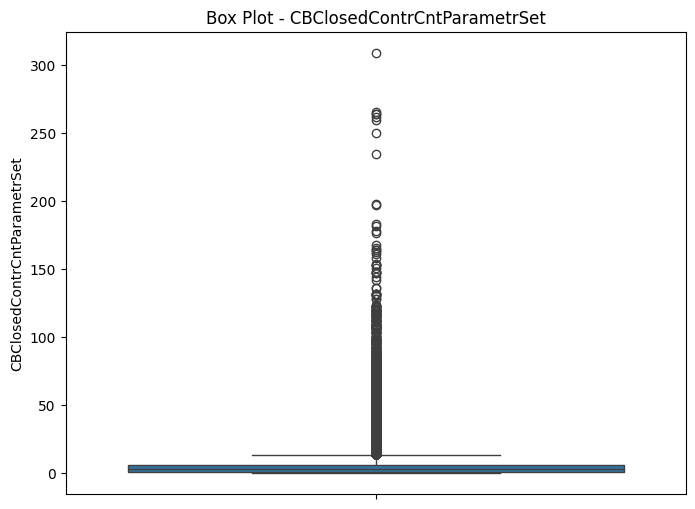

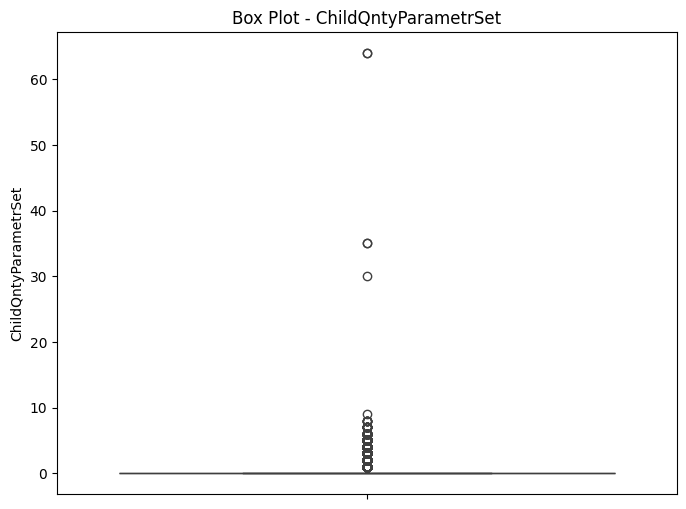

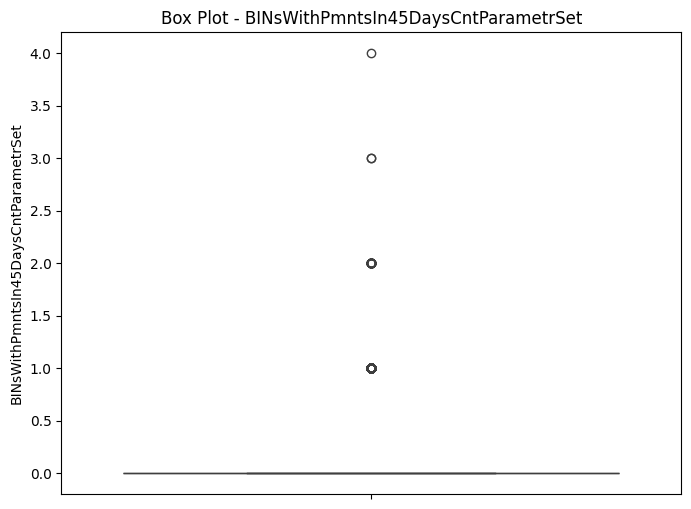

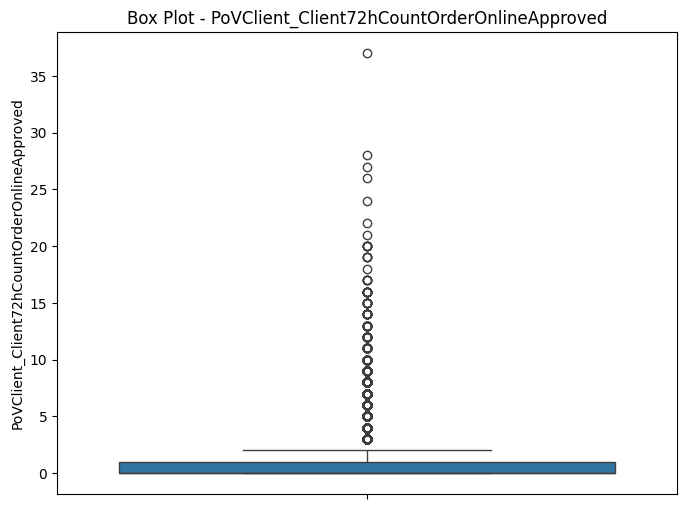

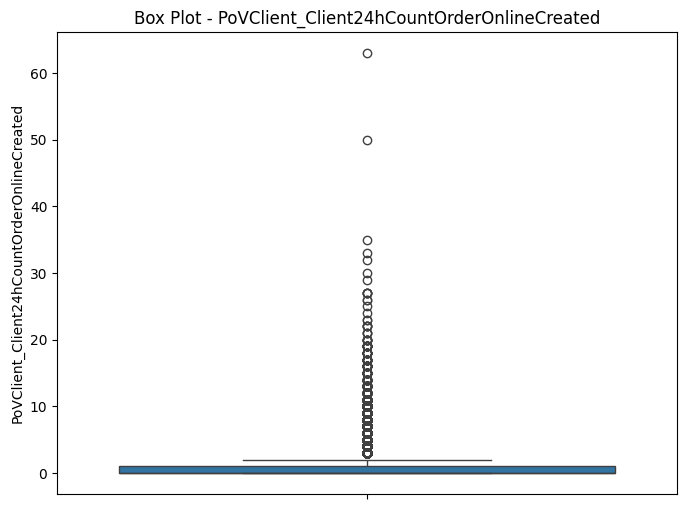

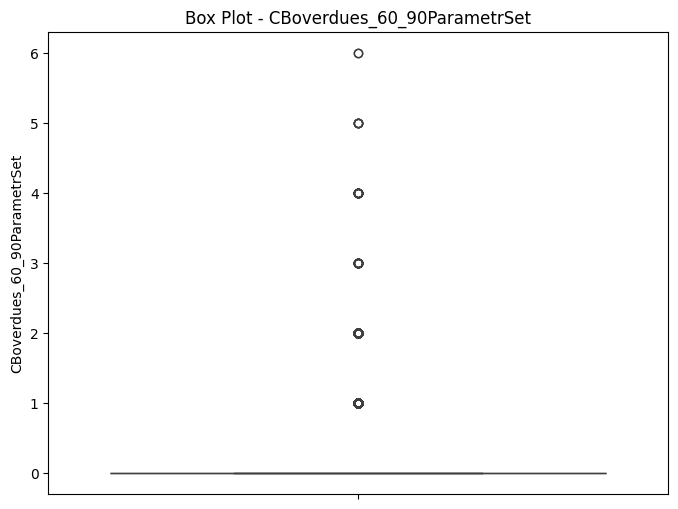

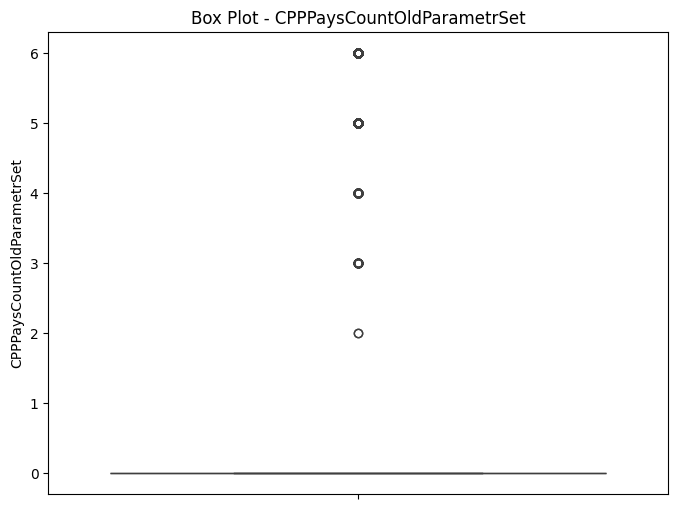

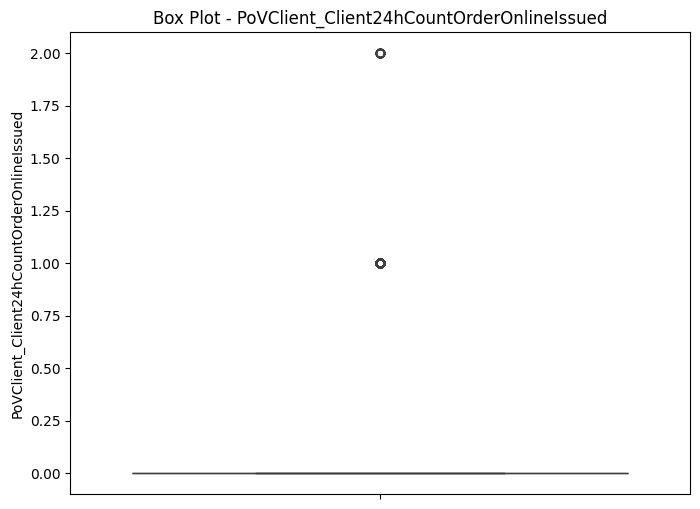

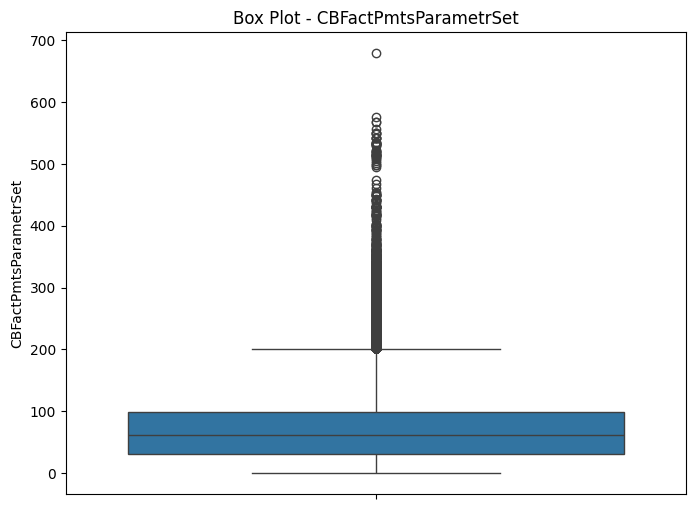

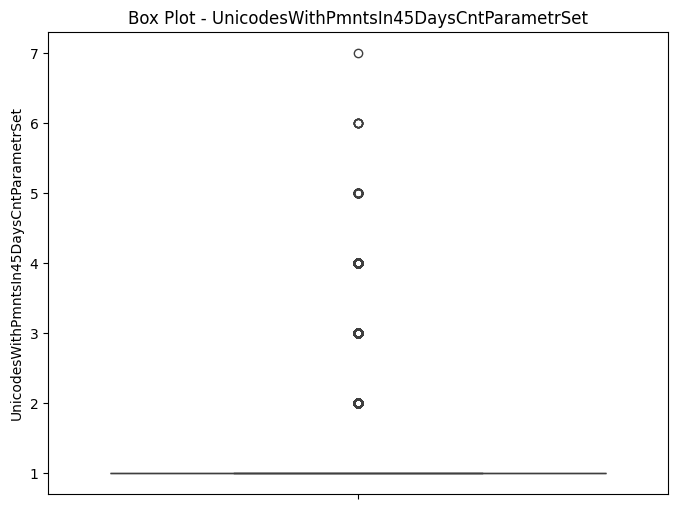

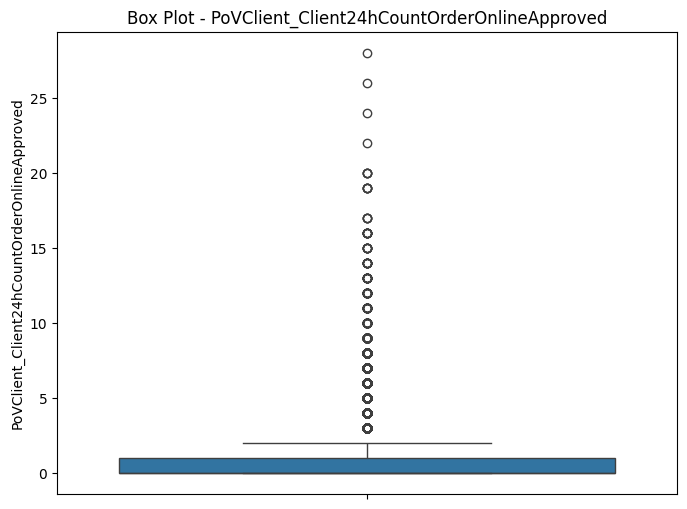

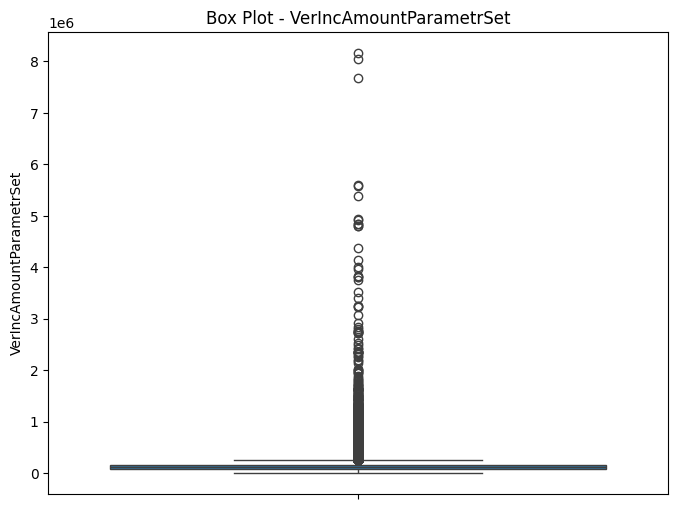

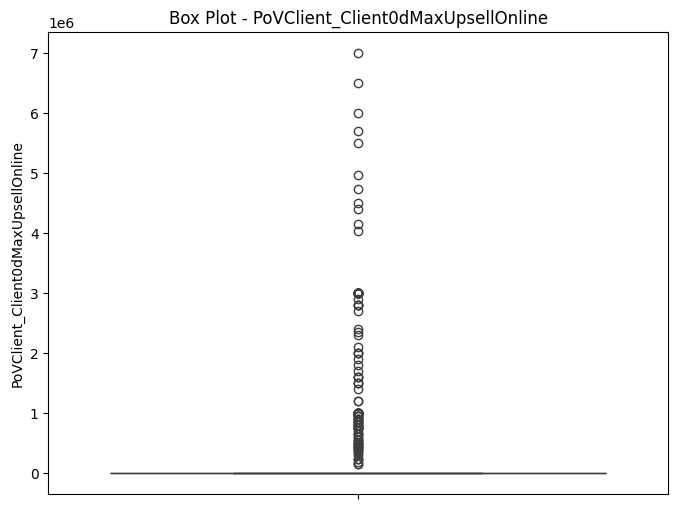

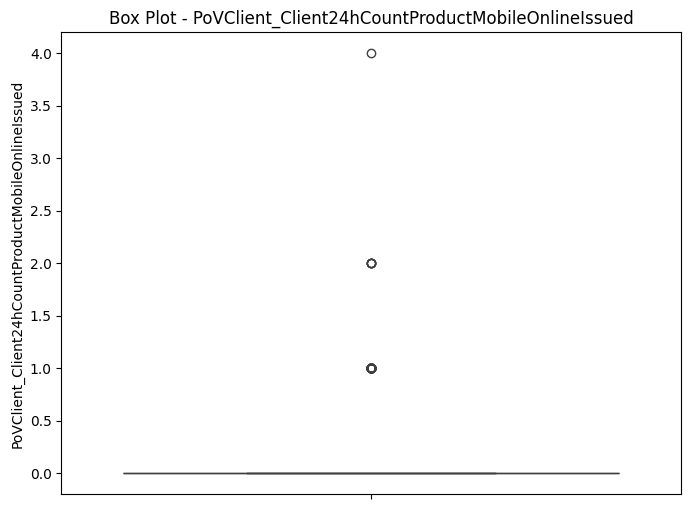

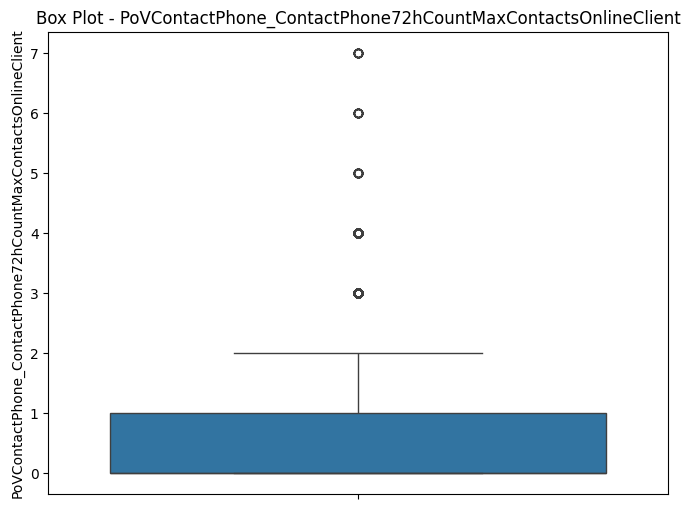

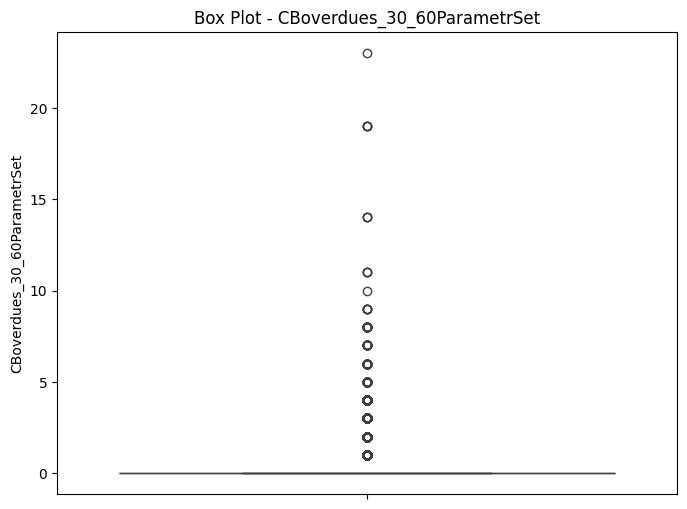

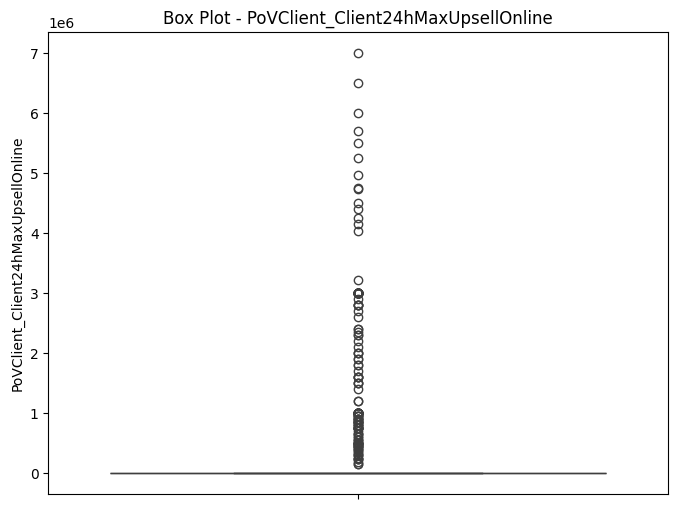

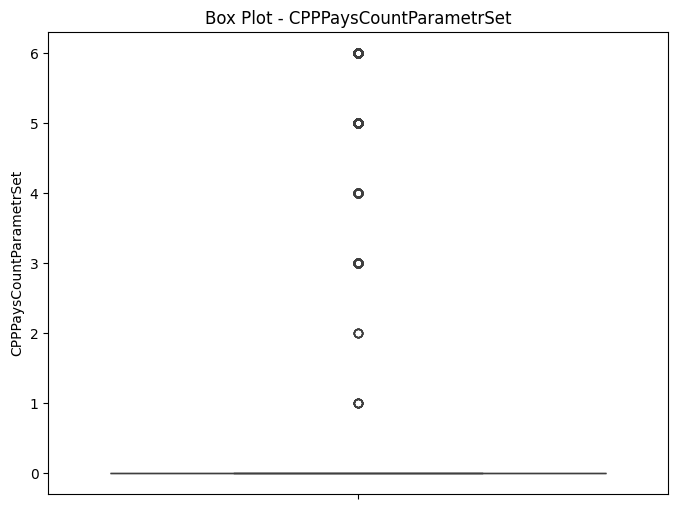

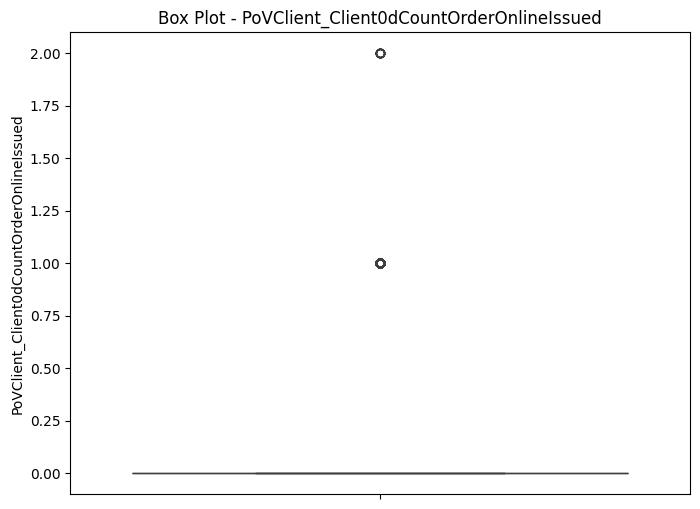

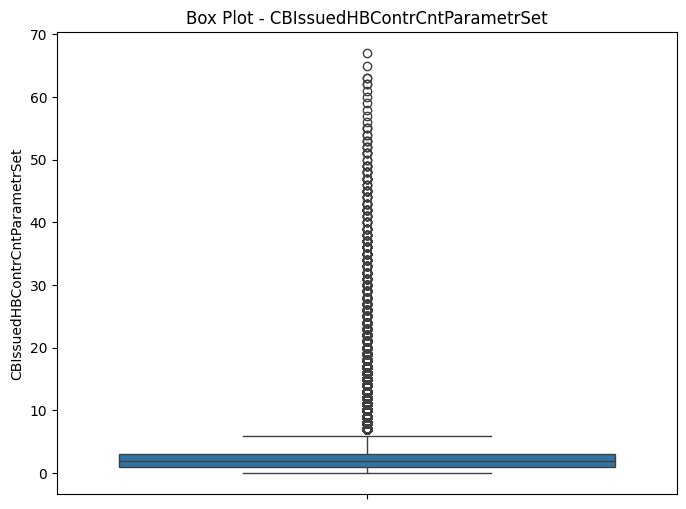

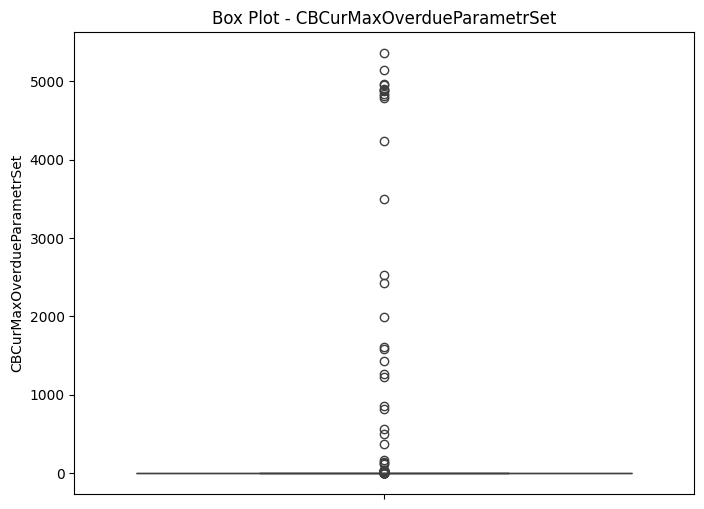

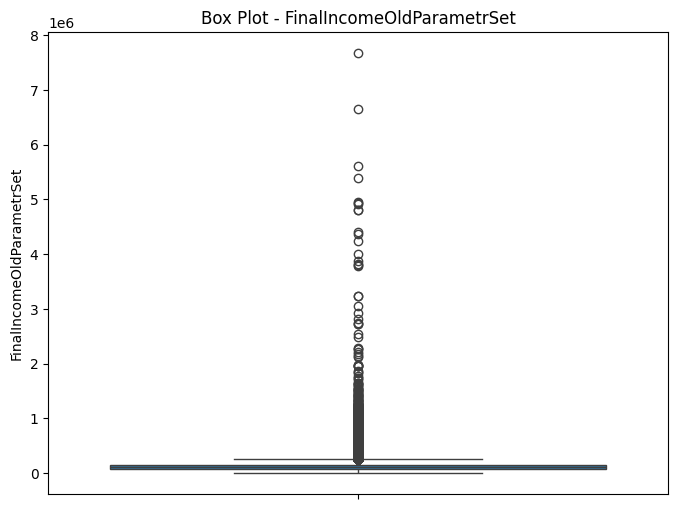

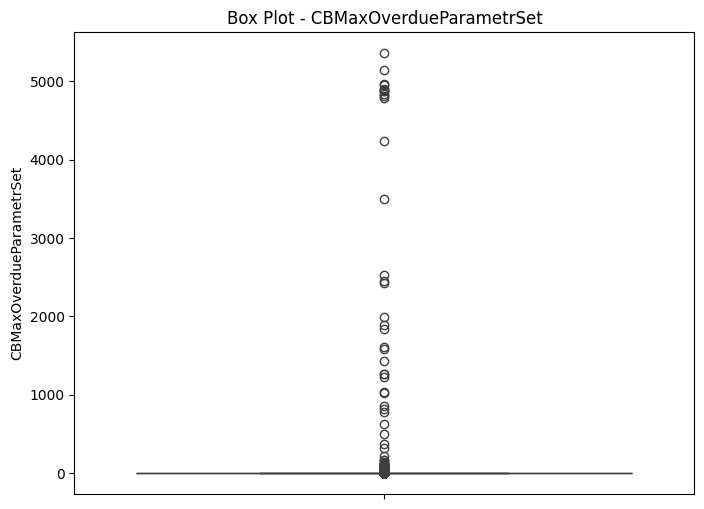

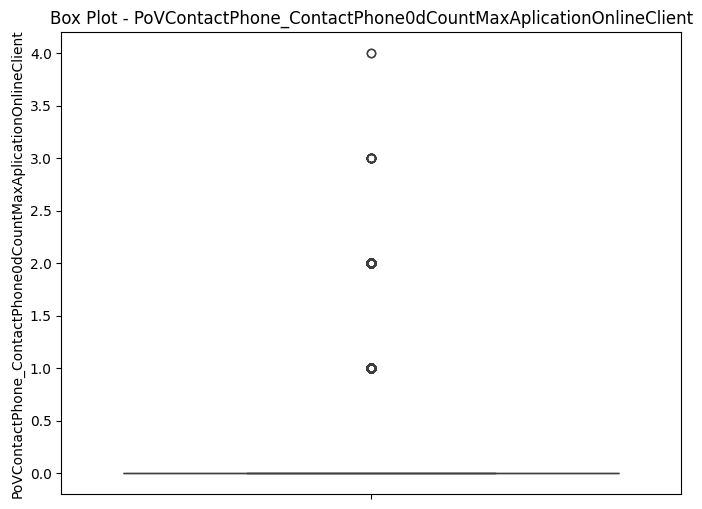

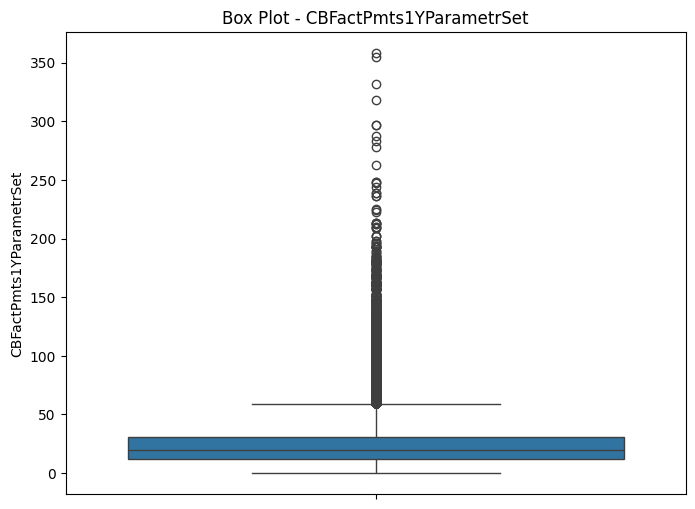

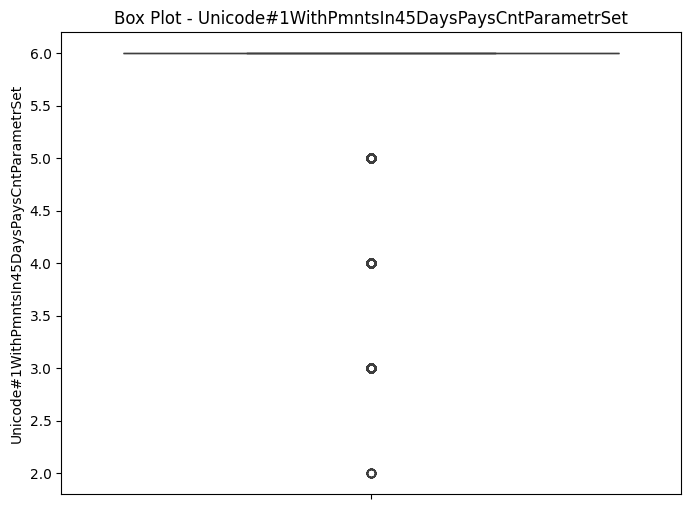

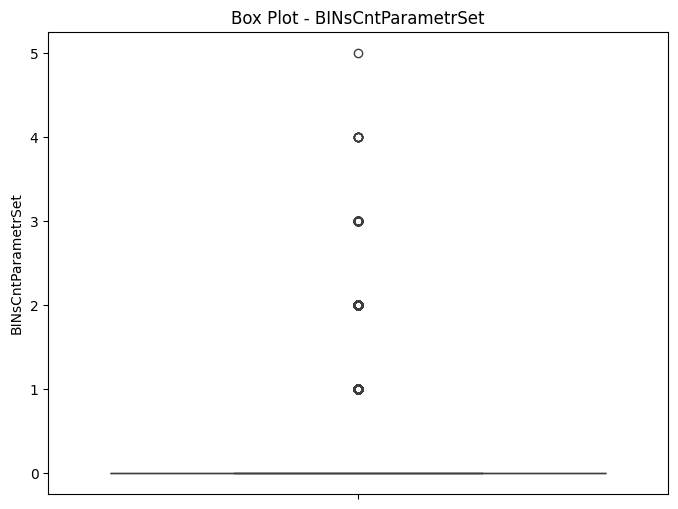

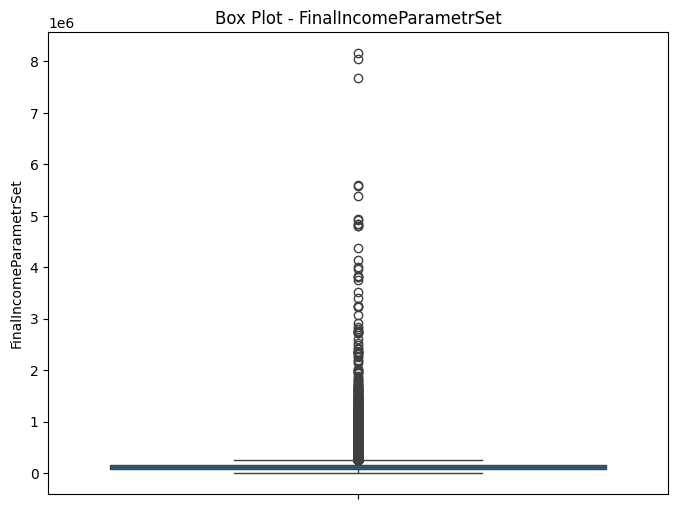

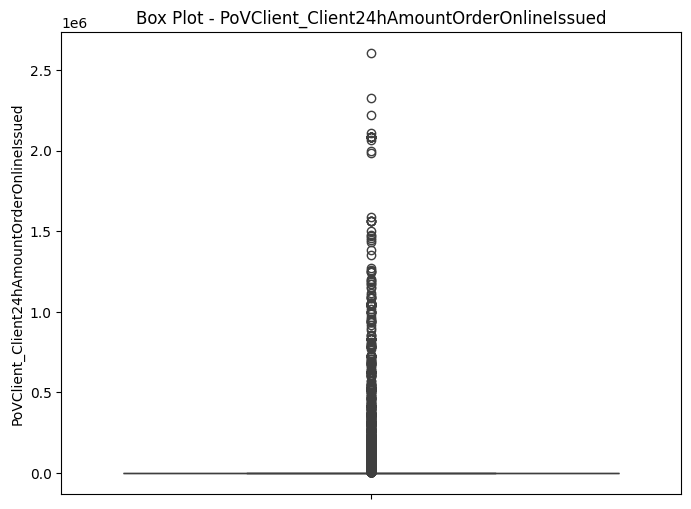

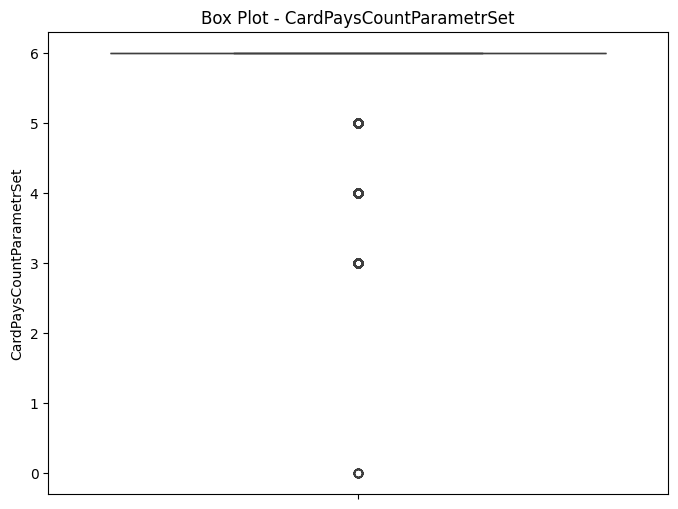

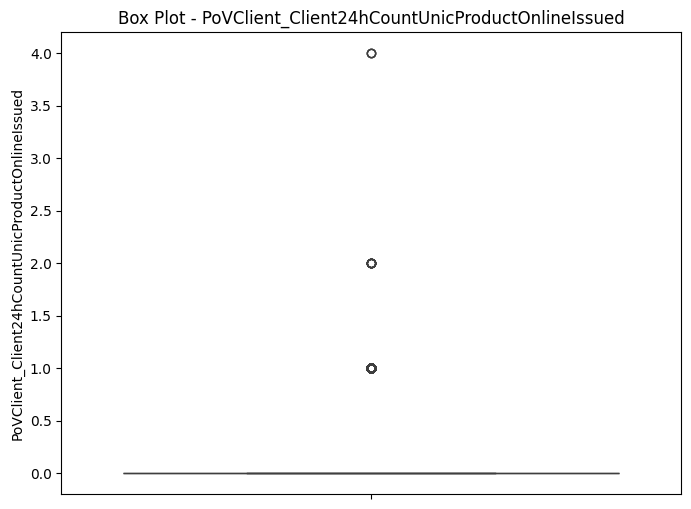

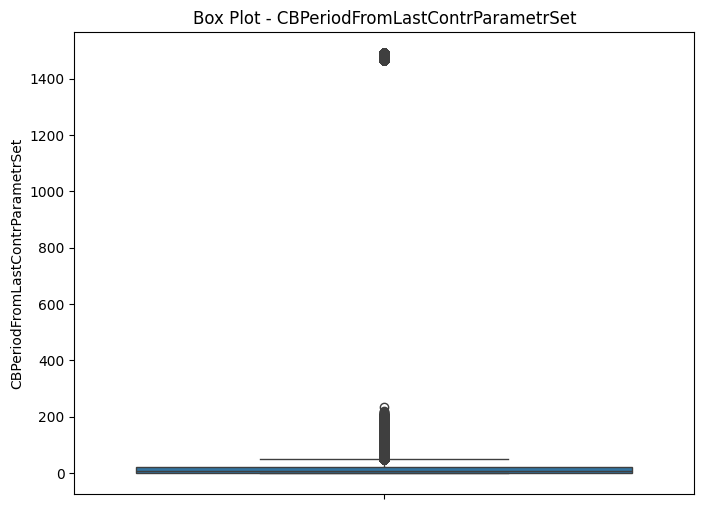

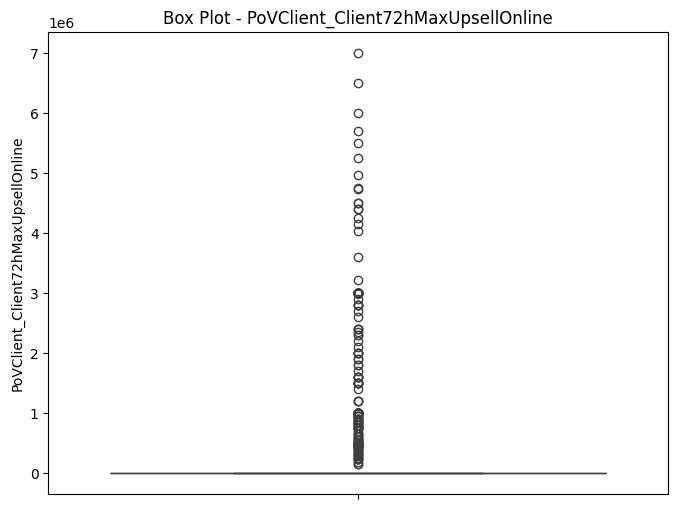

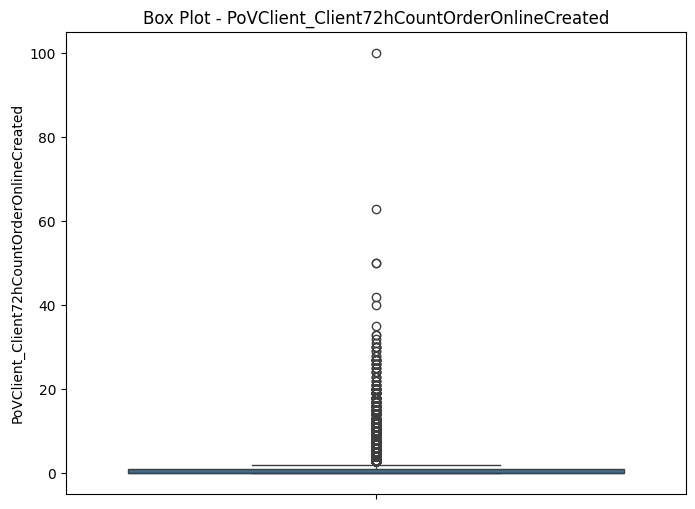

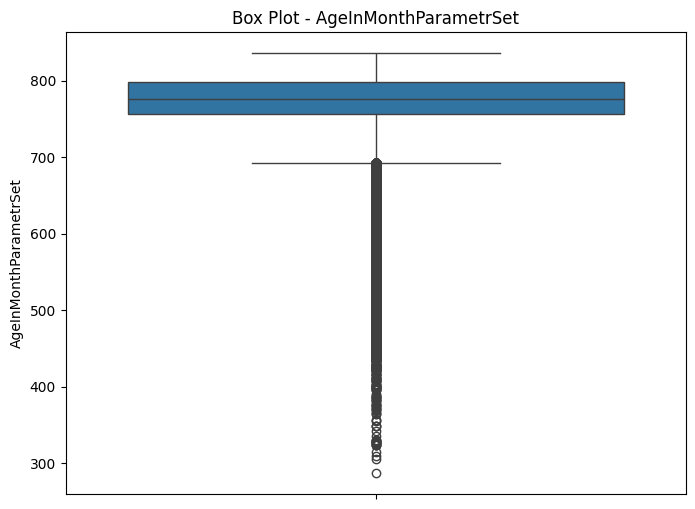

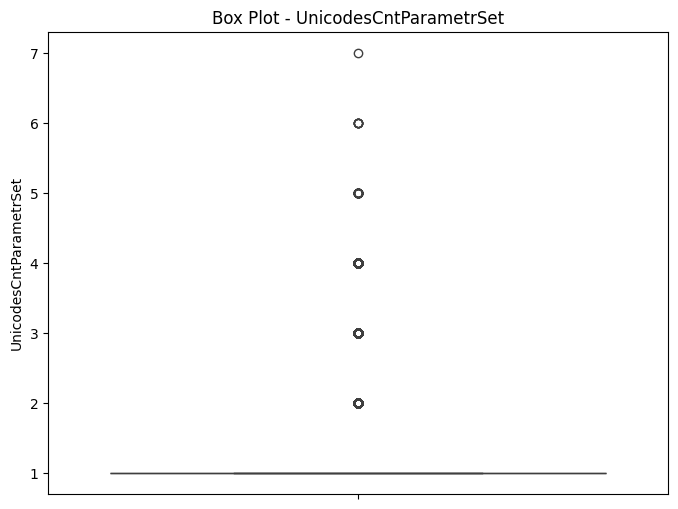

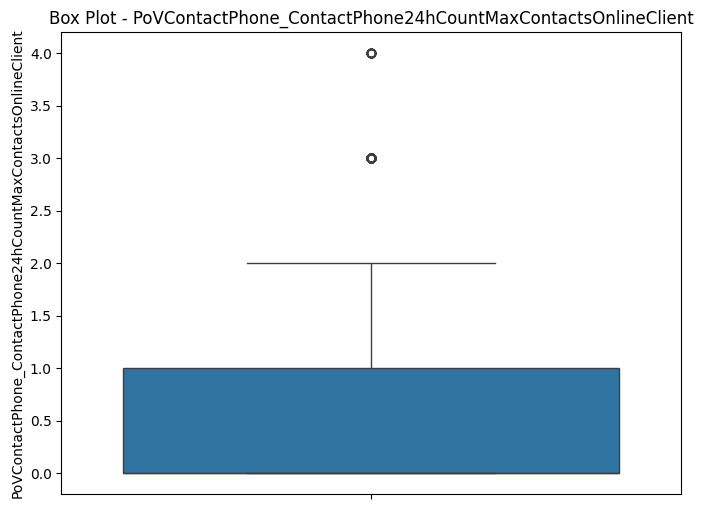

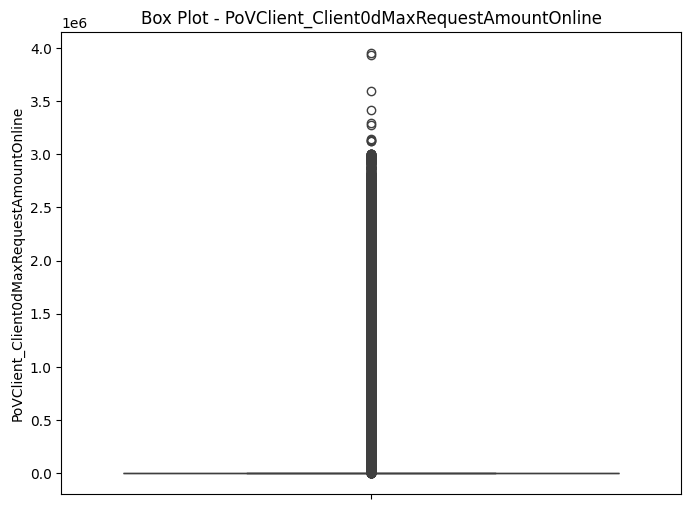

Columns with outliers:
['CBClosedContrCntParametrSet', 'ChildQntyParametrSet', 'BINsWithPmntsIn45DaysCntParametrSet', 'PoVClient_Client72hCountOrderOnlineApproved', 'PoVClient_Client24hCountOrderOnlineCreated', 'CBoverdues_60_90ParametrSet', 'CPPPaysCountOldParametrSet', 'PoVClient_Client24hCountOrderOnlineIssued', 'CBFactPmtsParametrSet', 'UnicodesWithPmntsIn45DaysCntParametrSet', 'PoVClient_Client24hCountOrderOnlineApproved', 'VerIncAmountParametrSet', 'PoVClient_Client0dMaxUpsellOnline', 'PoVClient_Client24hCountProductMobileOnlineIssued', 'PoVContactPhone_ContactPhone72hCountMaxContactsOnlineClient', 'CBoverdues_30_60ParametrSet', 'PoVClient_Client24hMaxUpsellOnline', 'CPPPaysCountParametrSet', 'PoVClient_Client0dCountOrderOnlineIssued', 'CBIssuedHBContrCntParametrSet', 'CBCurMaxOverdueParametrSet', 'FinalIncomeOldParametrSet', 'CBMaxOverdueParametrSet', 'PoVContactPhone_ContactPhone0dCountMaxAplicationOnlineClient', 'CBFactPmts1YParametrSet', 'Unicode#1WithPmntsIn45DaysPaysCntPara

In [19]:
#просмотр outliers в датафрейме для переменных типа int
float_columns = dataprep.select_dtypes(include = ['int']).columns
outlier_columns = []
for column in float_columns:
    z_scores = np.abs(stats.zscore(dataprep[column]))
    threshold = 7
    outliers = np.where(z_scores > threshold)[0]
    if len(outliers) > 0:
        outlier_columns.append(column)
        plt.figure(figsize=(8,6))
        sns.boxplot(data = dataprep[column])
        plt.title(f'Box Plot - {column}')
        plt.show()
print('Columns with outliers:')
print(outlier_columns)        

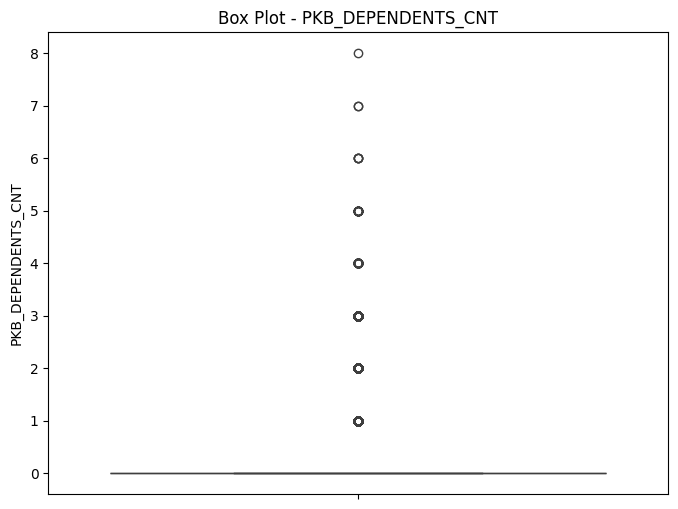

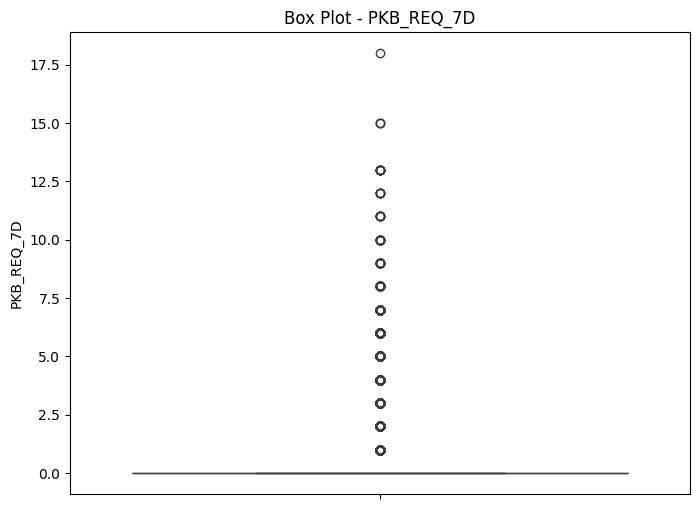

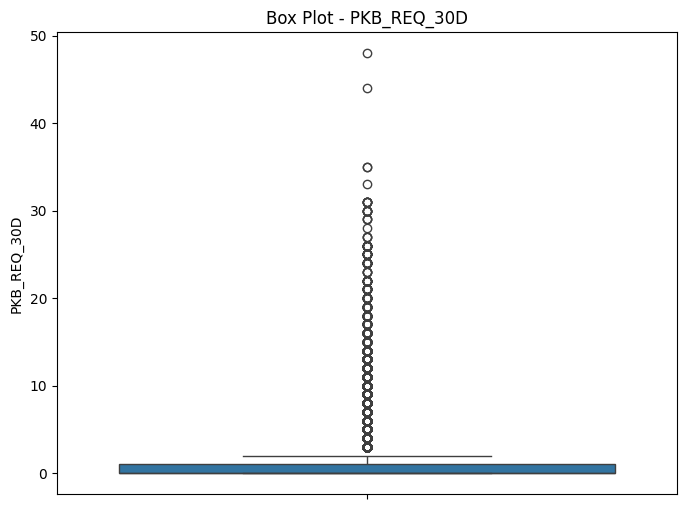

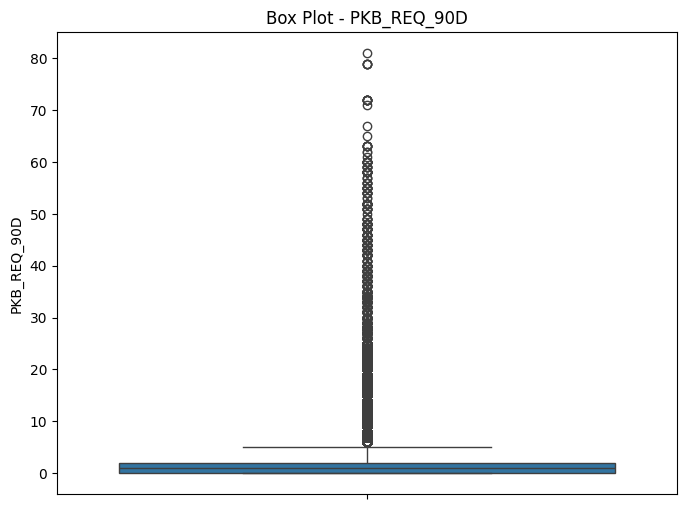

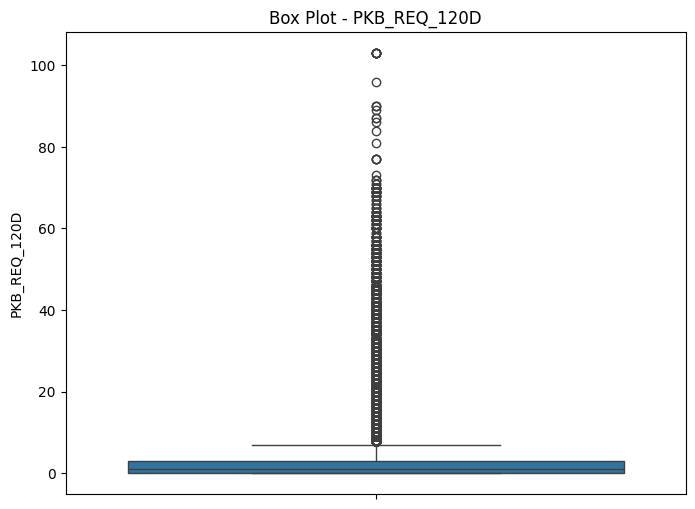

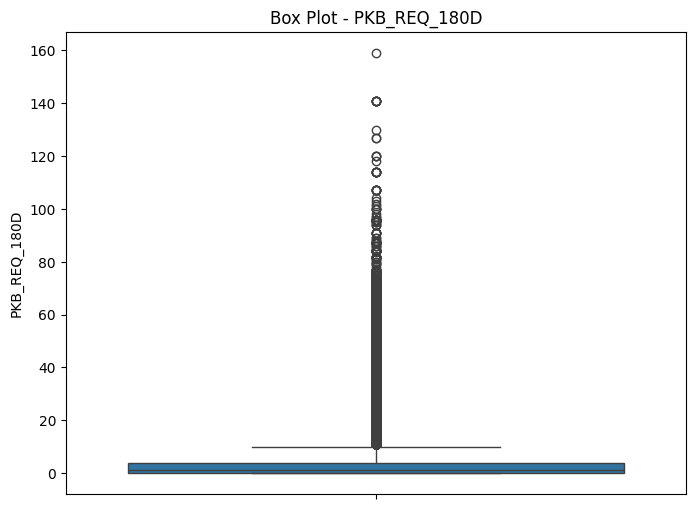

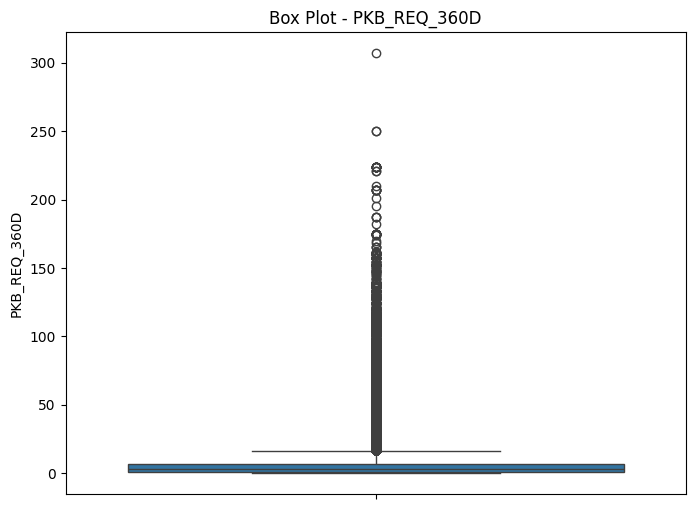

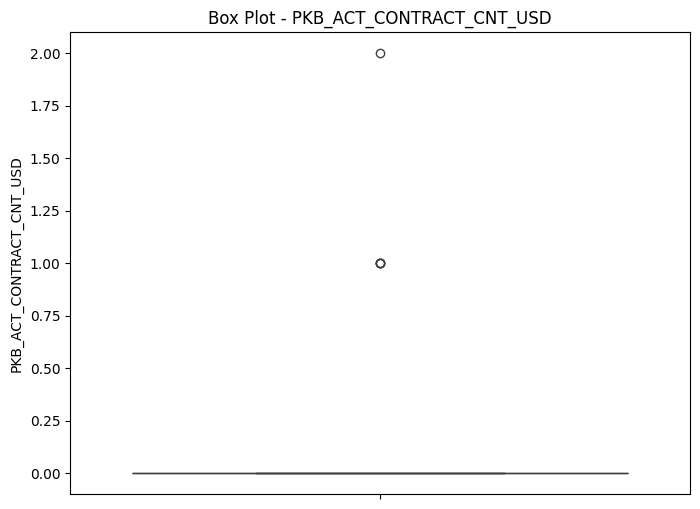

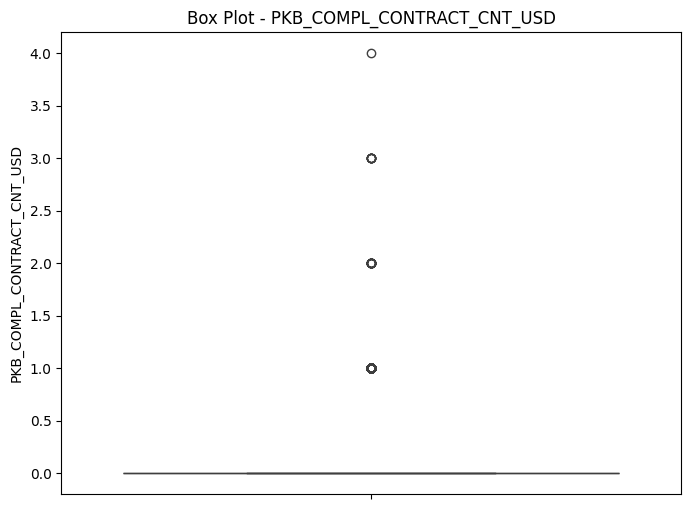

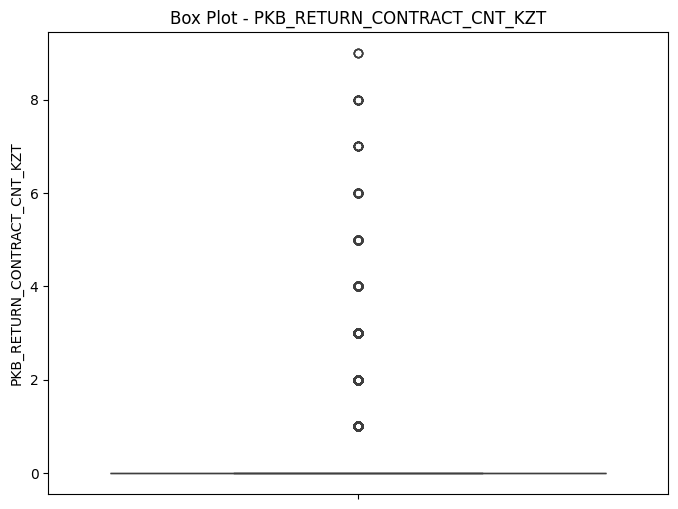

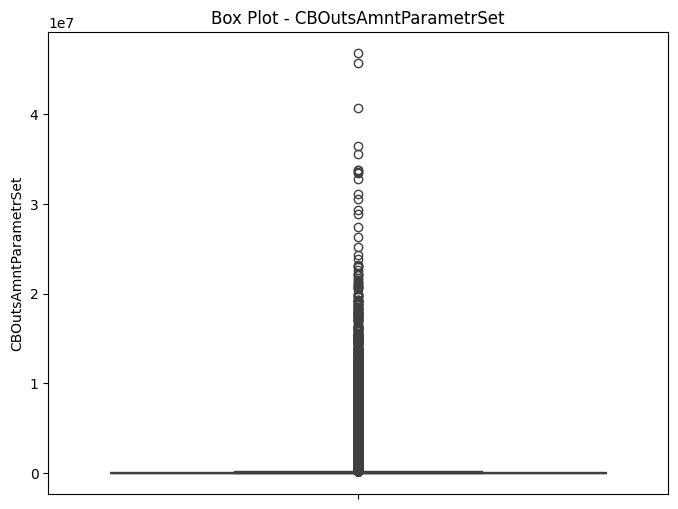

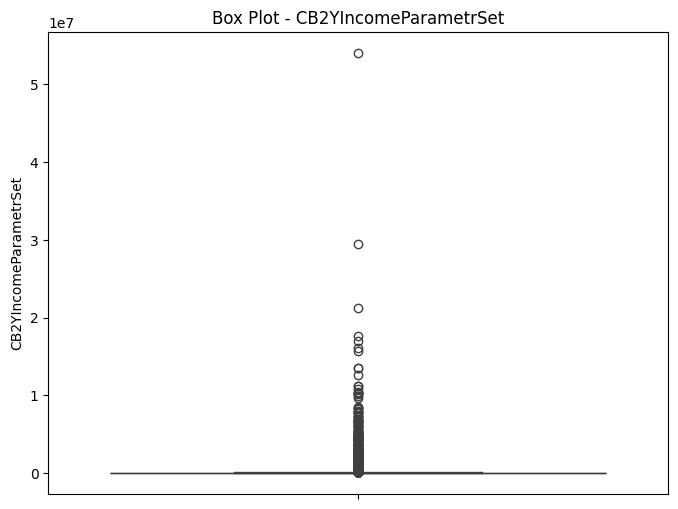

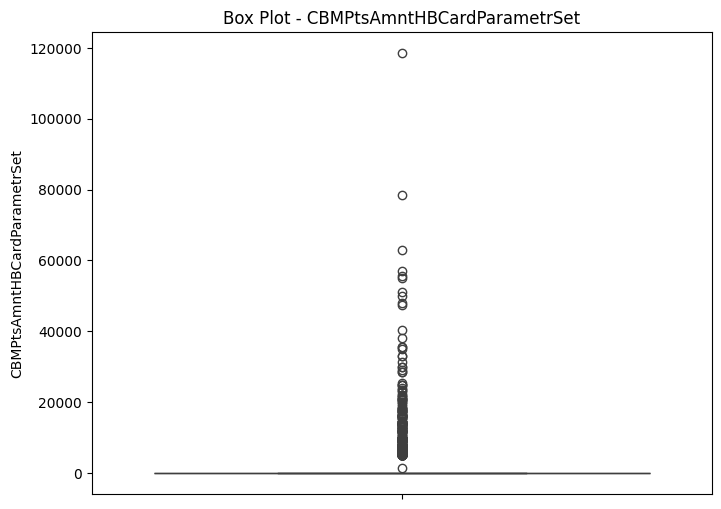

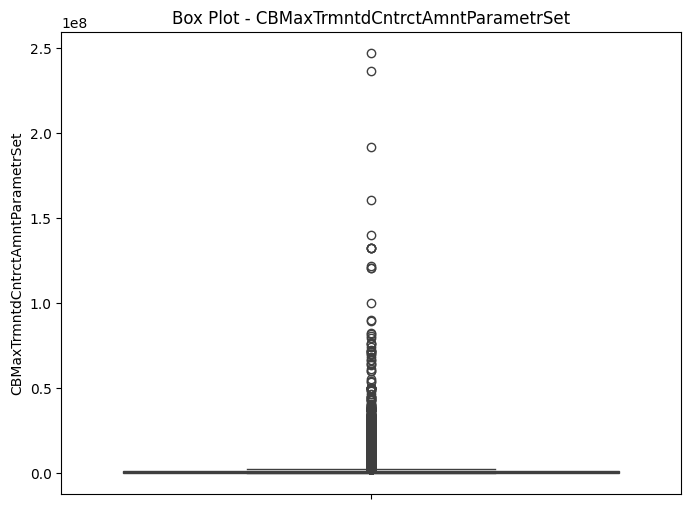

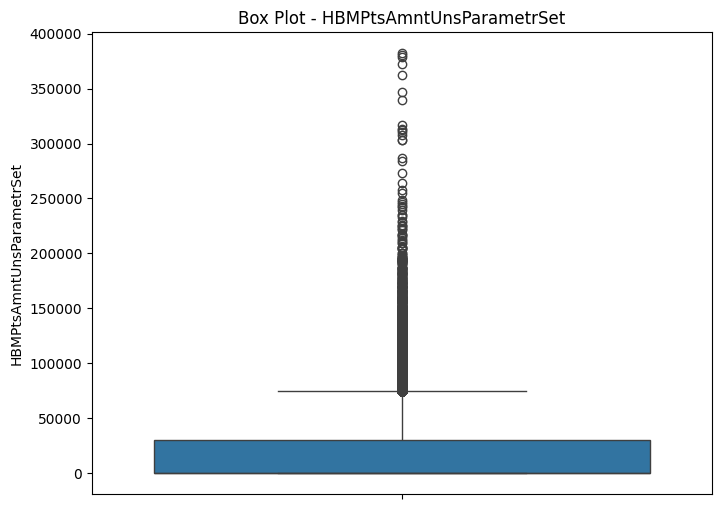

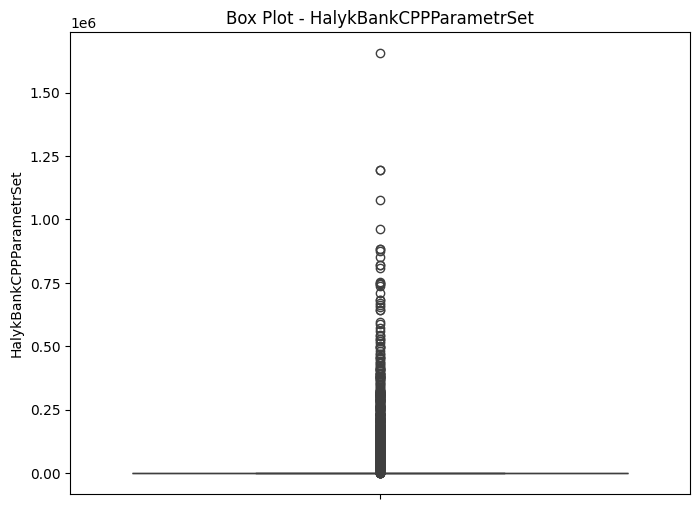

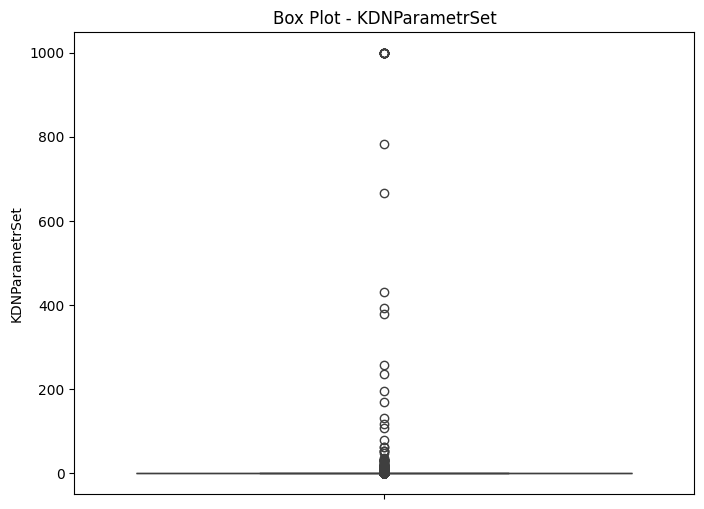

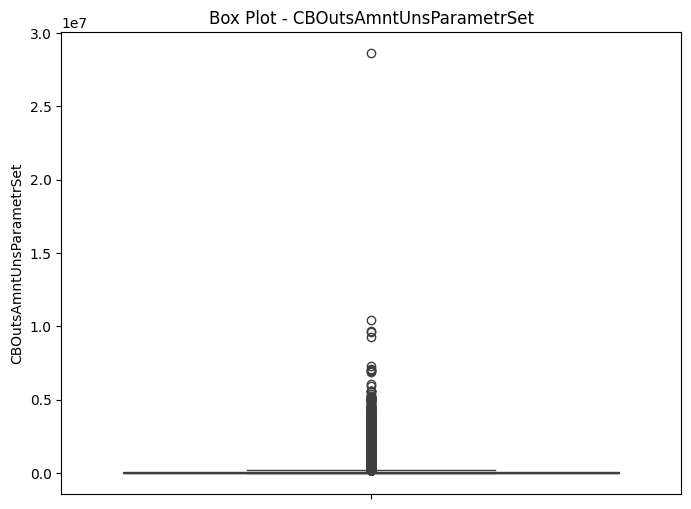

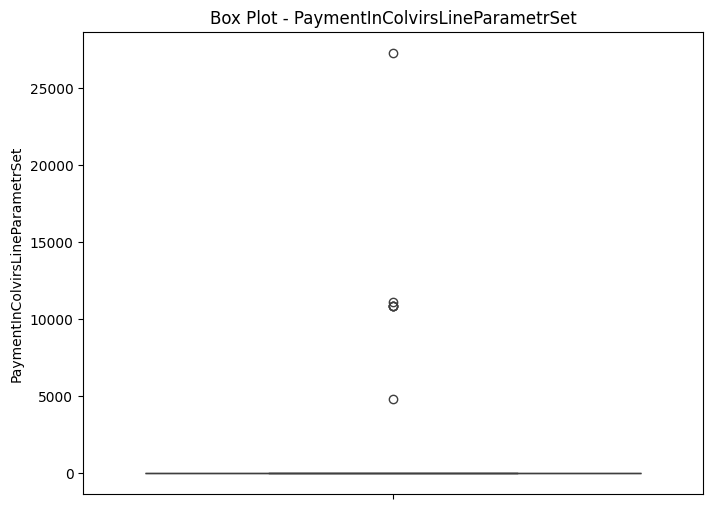

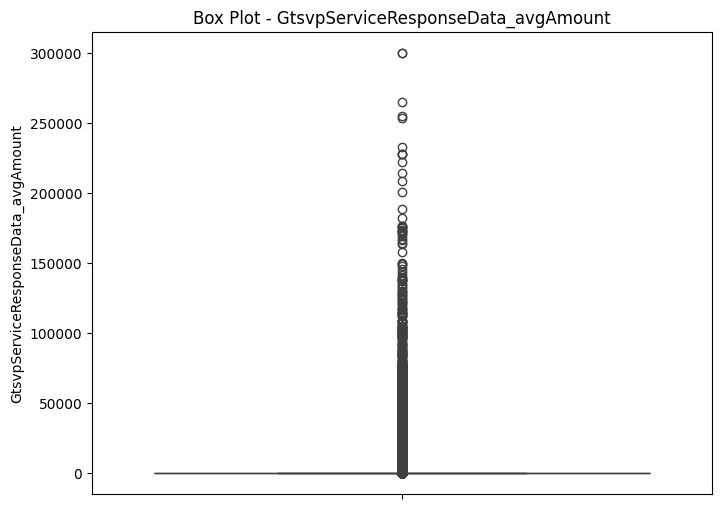

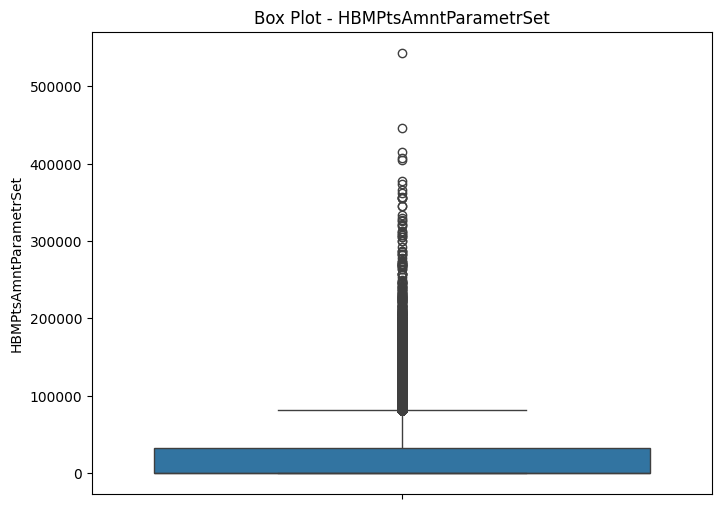

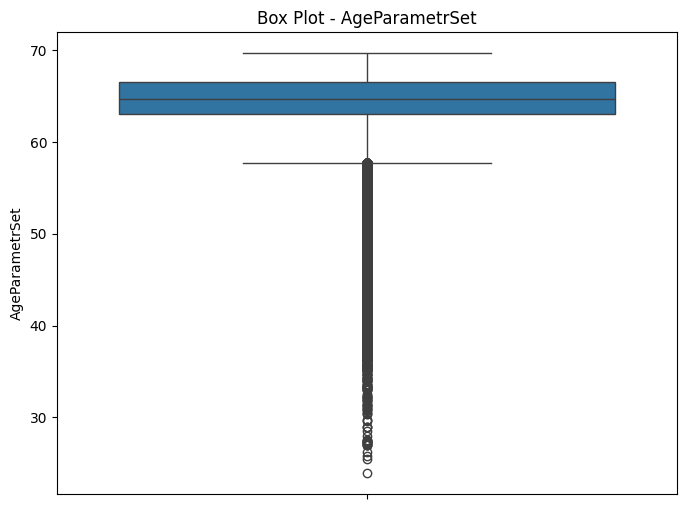

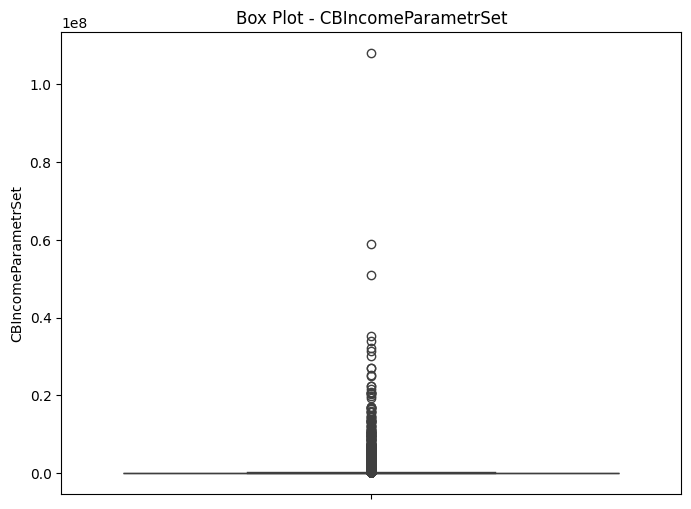

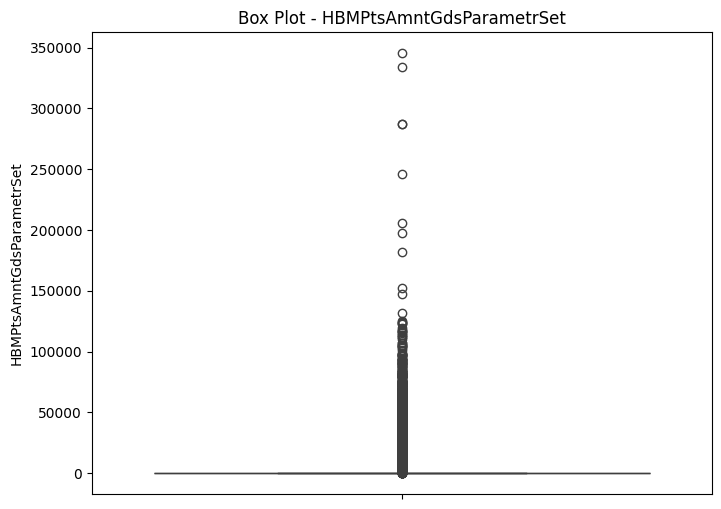

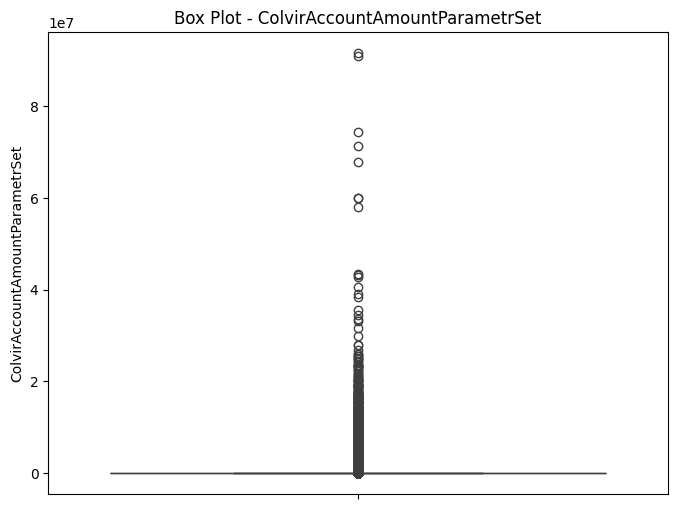

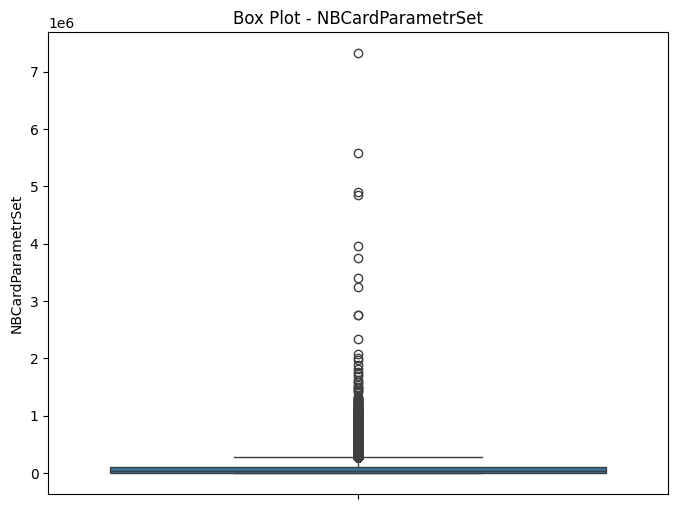

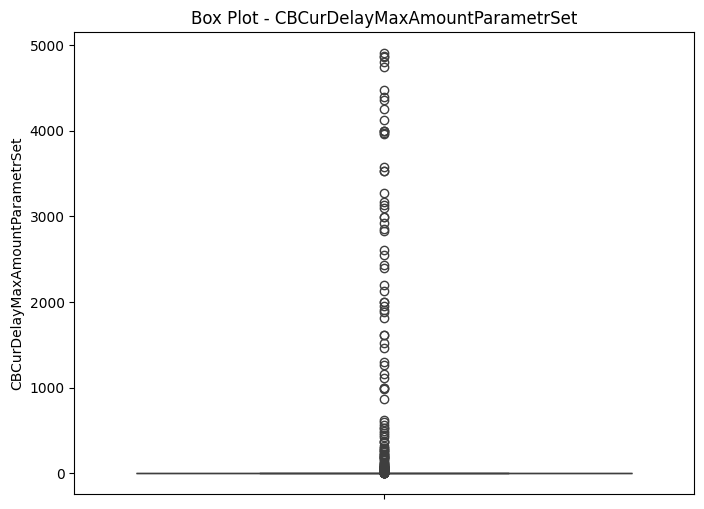

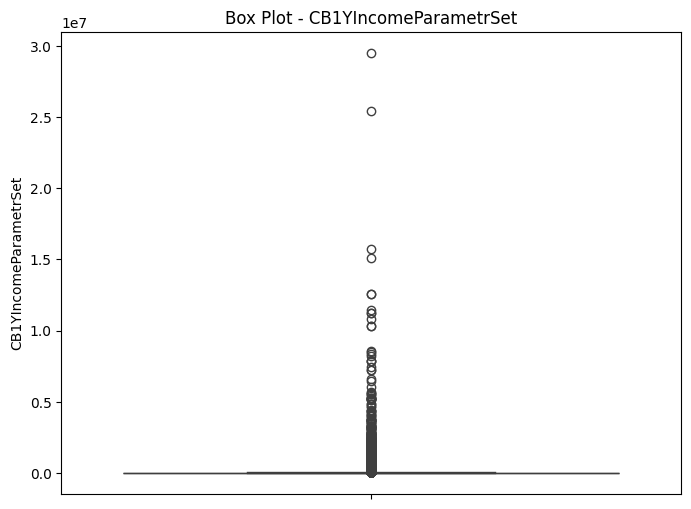

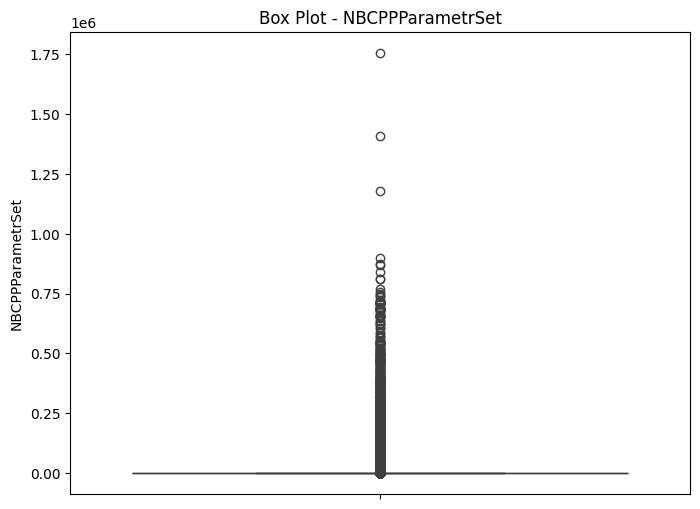

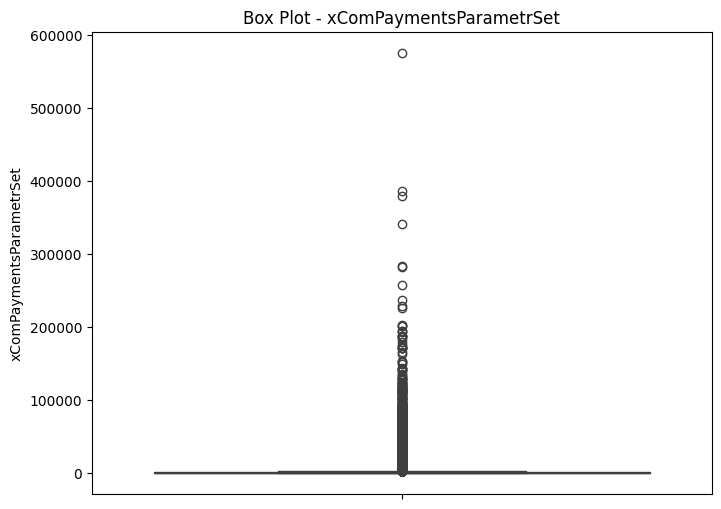

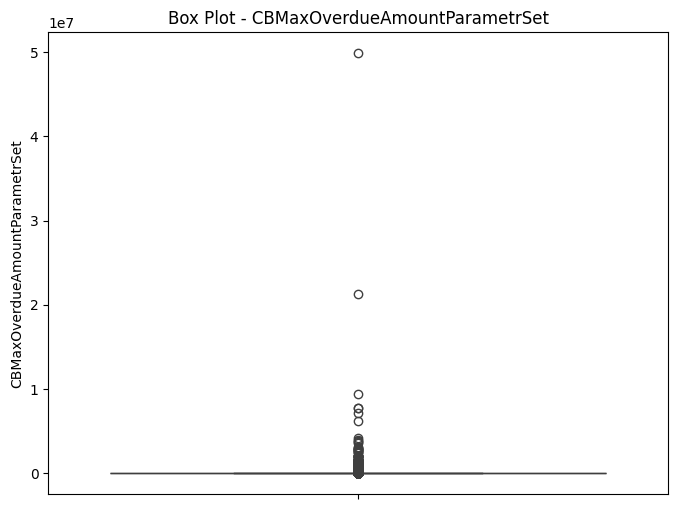

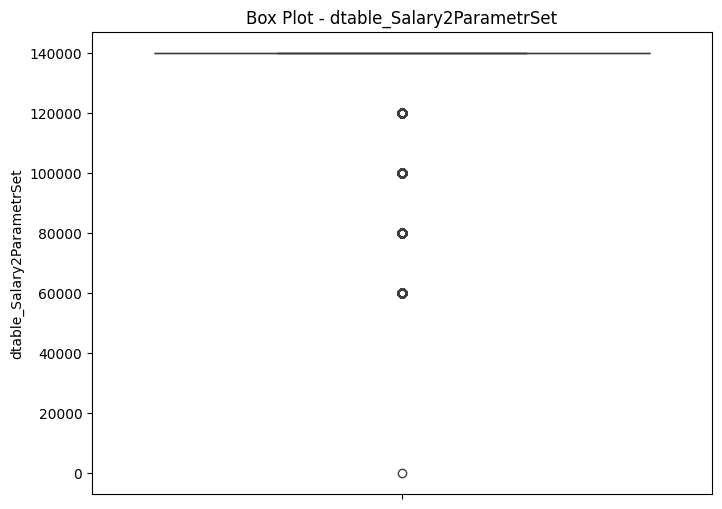

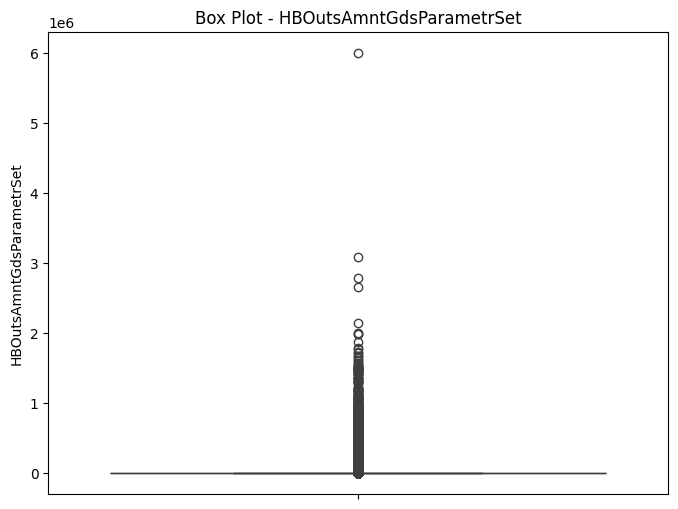

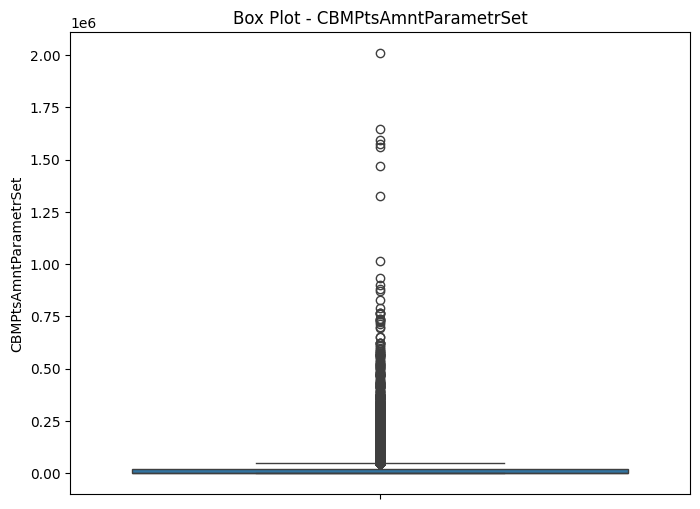

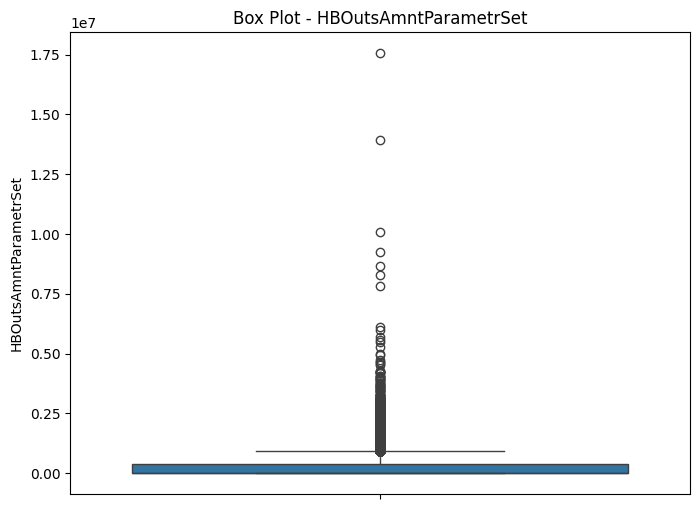

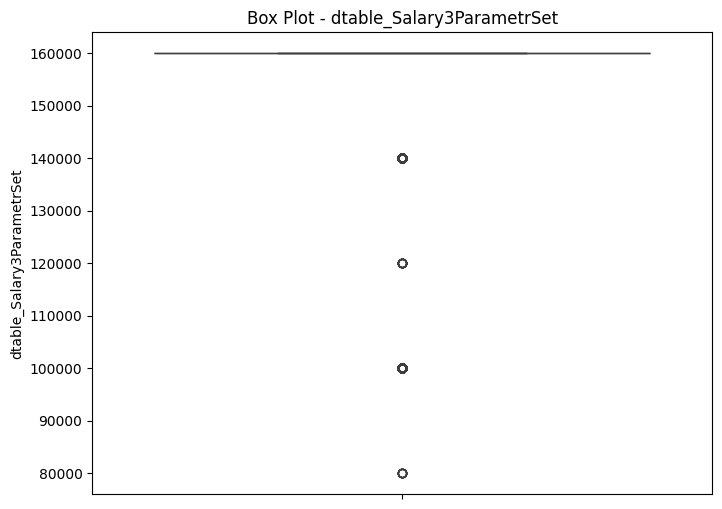

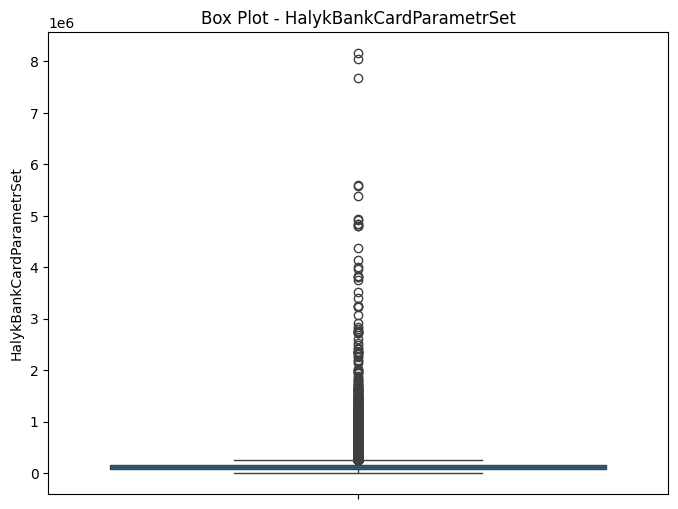

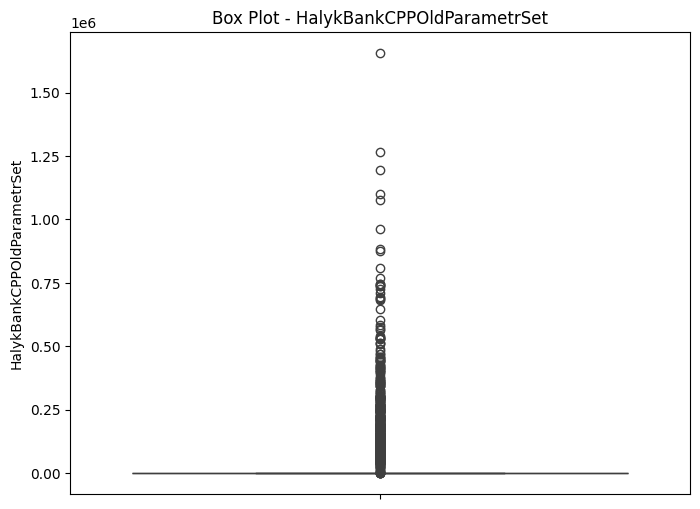

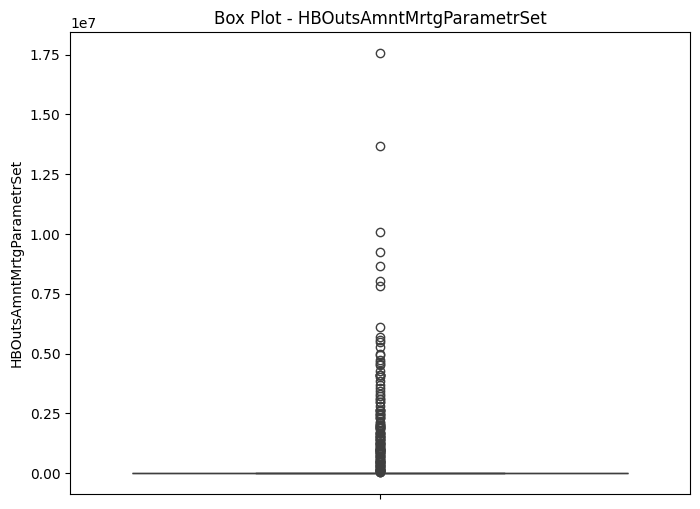

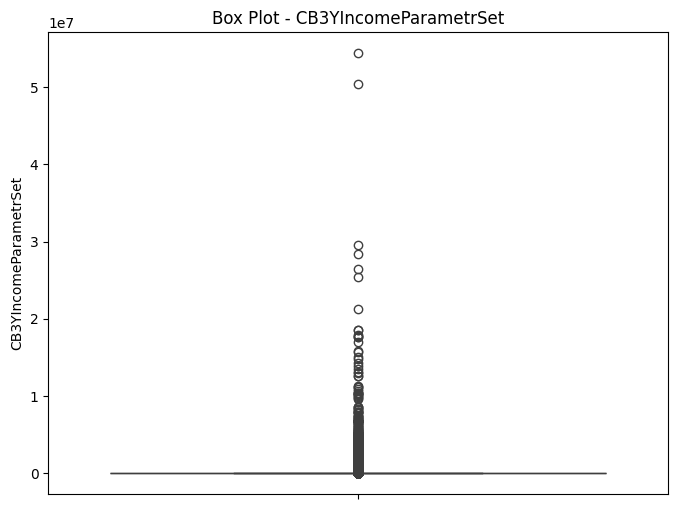

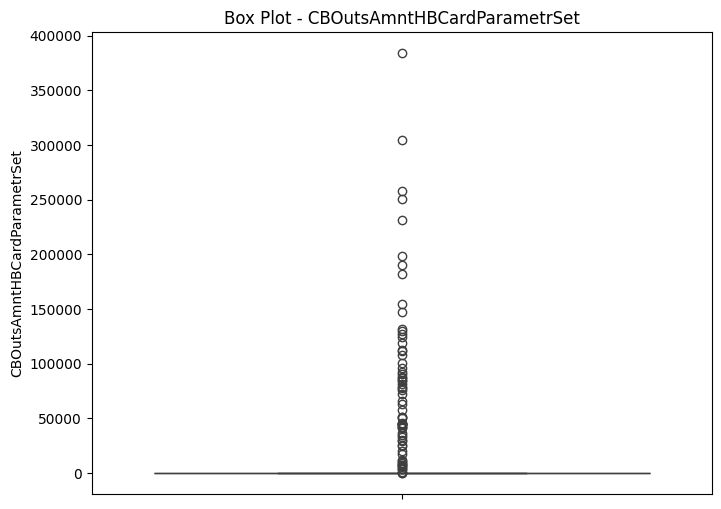

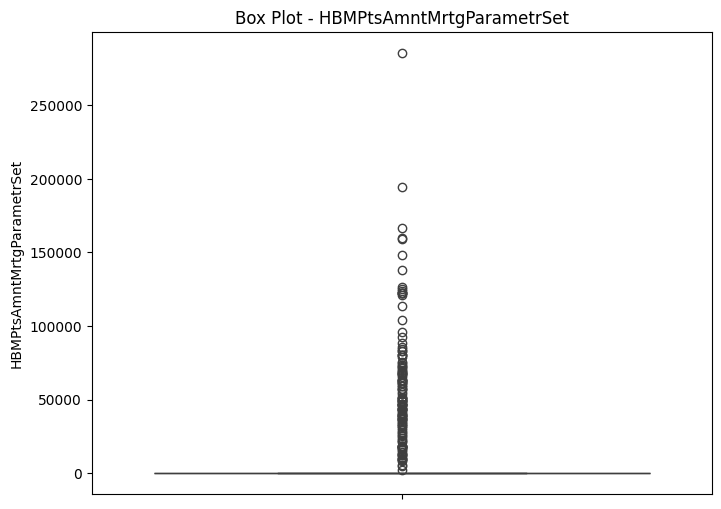

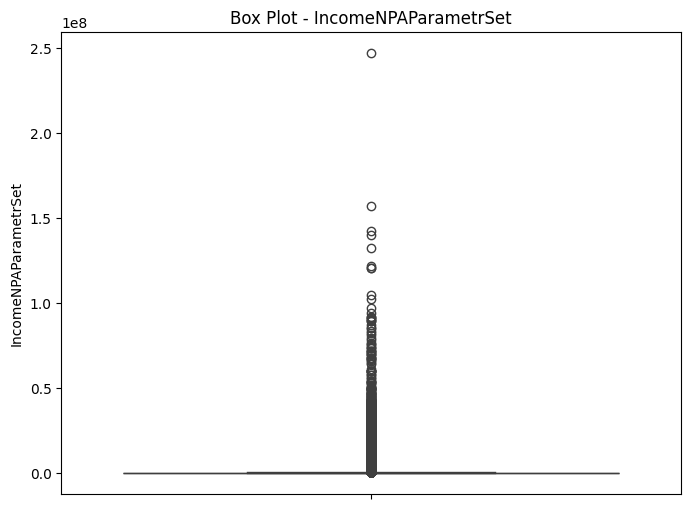

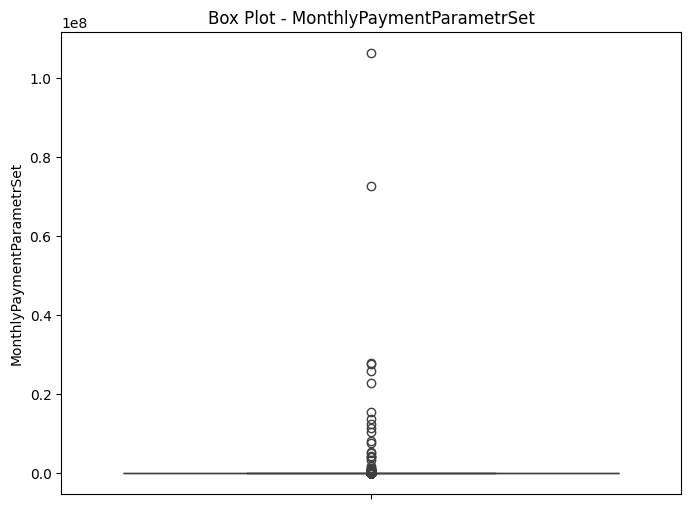

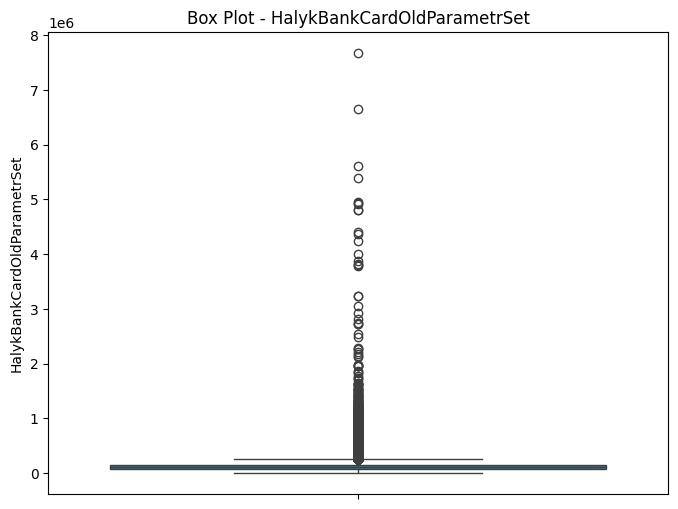

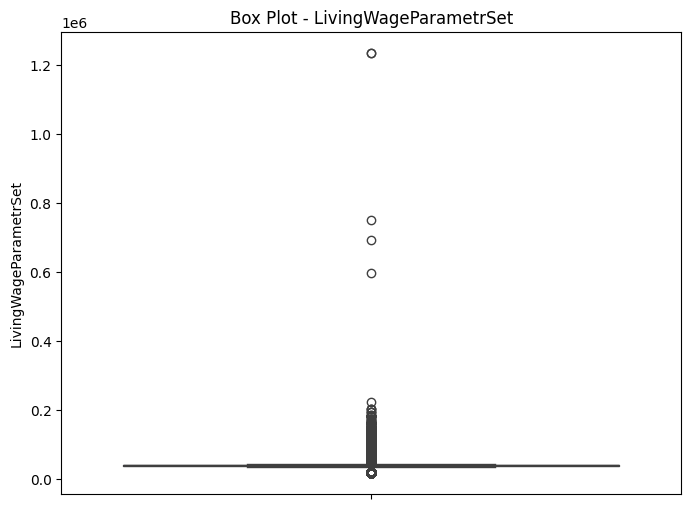

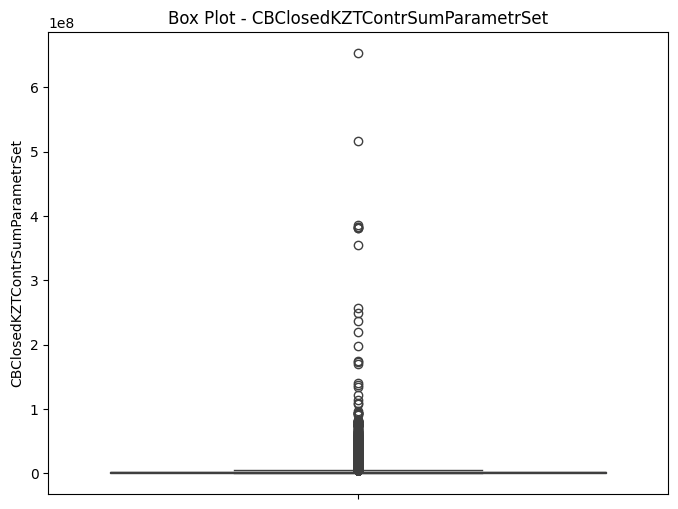

Columns with outliers:
['PKB_DEPENDENTS_CNT', 'PKB_REQ_7D', 'PKB_REQ_30D', 'PKB_REQ_90D', 'PKB_REQ_120D', 'PKB_REQ_180D', 'PKB_REQ_360D', 'PKB_ACT_CONTRACT_CNT_USD', 'PKB_COMPL_CONTRACT_CNT_USD', 'PKB_RETURN_CONTRACT_CNT_KZT', 'CBOutsAmntParametrSet', 'CB2YIncomeParametrSet', 'CBMPtsAmntHBCardParametrSet', 'CBMaxTrmntdCntrctAmntParametrSet', 'HBMPtsAmntUnsParametrSet', 'HalykBankCPPParametrSet', 'KDNParametrSet', 'CBOutsAmntUnsParametrSet', 'PaymentInColvirsLineParametrSet', 'GtsvpServiceResponseData_avgAmount', 'HBMPtsAmntParametrSet', 'AgeParametrSet', 'CBIncomeParametrSet', 'HBMPtsAmntGdsParametrSet', 'ColvirAccountAmountParametrSet', 'NBCardParametrSet', 'CBCurDelayMaxAmountParametrSet', 'CB1YIncomeParametrSet', 'NBCPPParametrSet', 'xComPaymentsParametrSet', 'CBMaxOverdueAmountParametrSet', 'dtable_Salary2ParametrSet', 'HBOutsAmntGdsParametrSet', 'CBMPtsAmntParametrSet', 'HBOutsAmntParametrSet', 'dtable_Salary3ParametrSet', 'HalykBankCardParametrSet', 'HalykBankCPPOldParametrSet', 

In [20]:
#просмотр outliers в датафрейме среди переменных типа floa64
float_columns = dataprep.select_dtypes(include = [np.float64]).columns
outlier_columns = []
for column in float_columns:
    z_scores = np.abs(stats.zscore(dataprep[column]))
    threshold = 7
    outliers = np.where(z_scores > threshold)[0]
    if len(outliers) > 0:
        outlier_columns.append(column)
        plt.figure(figsize=(8,6))
        sns.boxplot(data = dataprep[column])
        plt.title(f'Box Plot - {column}')
        plt.show()
print('Columns with outliers:')
print(outlier_columns)        

In [21]:
#Замена аномальных отклонений на средние значения переменной
dataprep['CBClosedContrCntParametrSet'] = np.where(dataprep['CBClosedContrCntParametrSet']>200, dataprep['CBClosedContrCntParametrSet'].mean(), dataprep['CBClosedContrCntParametrSet'])
dataprep['ChildQntyParametrSet'] = np.where(dataprep['ChildQntyParametrSet']>10, dataprep['ChildQntyParametrSet'].mean(), dataprep['ChildQntyParametrSet'])
dataprep['PoVClient_Client24hCountOrderOnlineApproved'] = np.where(dataprep['PoVClient_Client24hCountOrderOnlineApproved']>10, dataprep['PoVClient_Client24hCountOrderOnlineApproved'].mean(), dataprep['PoVClient_Client24hCountOrderOnlineApproved'])
dataprep['VerIncAmountParametrSet'] = np.where(dataprep['VerIncAmountParametrSet']>4000000, dataprep['VerIncAmountParametrSet'].mean(), dataprep['VerIncAmountParametrSet'])
dataprep['PoVClient_Client0dMaxUpsellOnline'] = np.where(dataprep['PoVClient_Client0dMaxUpsellOnline']>6000000, dataprep['PoVClient_Client0dMaxUpsellOnline'].mean(), dataprep['PoVClient_Client0dMaxUpsellOnline'])
dataprep['PoVClient_Client24hMaxUpsellOnline'] = np.where(dataprep['PoVClient_Client24hMaxUpsellOnline']>6000000, dataprep['PoVClient_Client24hMaxUpsellOnline'].mean(), dataprep['PoVClient_Client24hMaxUpsellOnline'])
dataprep['FinalIncomeOldParametrSet'] = np.where(dataprep['FinalIncomeOldParametrSet']>5000000, dataprep['FinalIncomeOldParametrSet'].mean(), dataprep['FinalIncomeOldParametrSet'])
dataprep['FinalIncomeParametrSet'] = np.where(dataprep['FinalIncomeParametrSet']>7000000, dataprep['FinalIncomeParametrSet'].mean(), dataprep['FinalIncomeParametrSet'])
dataprep['PoVClient_Client72hMaxUpsellOnline'] = np.where(dataprep['PoVClient_Client72hMaxUpsellOnline']>6000000, dataprep['PoVClient_Client72hMaxUpsellOnline'].mean(), dataprep['PoVClient_Client72hMaxUpsellOnline'])
dataprep['CBIncomeParametrSet'] = np.where(dataprep['CBIncomeParametrSet']>25000000, dataprep['CBIncomeParametrSet'].mean(), dataprep['CBIncomeParametrSet'])
dataprep['ColvirAccountAmountParametrSet'] = np.where(dataprep['ColvirAccountAmountParametrSet']>25000000, dataprep['ColvirAccountAmountParametrSet'].mean(), dataprep['ColvirAccountAmountParametrSet'])
dataprep['NBCardParametrSet'] = np.where(dataprep['NBCardParametrSet']>4000000, dataprep['NBCardParametrSet'].mean(), dataprep['NBCardParametrSet'])
dataprep['CB1YIncomeParametrSet'] = np.where(dataprep['CB1YIncomeParametrSet']>15000000, dataprep['CB1YIncomeParametrSet'].mean(), dataprep['CB1YIncomeParametrSet'])
dataprep['CB3YIncomeParametrSet'] = np.where(dataprep['CB3YIncomeParametrSet']>20000000, dataprep['CB3YIncomeParametrSet'].mean(), dataprep['CB3YIncomeParametrSet'])
dataprep['IncomeNPAParametrSet'] = np.where(dataprep['IncomeNPAParametrSet']>100000000, dataprep['IncomeNPAParametrSet'].mean(), dataprep['IncomeNPAParametrSet'])
dataprep['MonthlyPaymentParametrSet'] = np.where(dataprep['MonthlyPaymentParametrSet']>10000000, dataprep['MonthlyPaymentParametrSet'].mean(), dataprep['MonthlyPaymentParametrSet'])
dataprep['HalykBankCardOldParametrSet'] = np.where(dataprep['HalykBankCardOldParametrSet']>5000000, dataprep['HalykBankCardOldParametrSet'].mean(), dataprep['HalykBankCardOldParametrSet'])
dataprep['CBClosedKZTContrSumParametrSet'] = np.where(dataprep['CBClosedKZTContrSumParametrSet']>200000000, dataprep['CBClosedKZTContrSumParametrSet'].mean(), dataprep['CBClosedKZTContrSumParametrSet'])


In [22]:
#Просмотр распределения переменной
dataprep['CBClosedKZTContrSumParametrSet'].describe()

count    2.246630e+05
mean     1.884902e+06
std      3.331299e+06
min      0.000000e+00
25%      3.150000e+05
50%      1.080000e+06
75%      2.262672e+06
max      1.975999e+08
Name: CBClosedKZTContrSumParametrSet, dtype: float64

In [23]:
#просмотр отклонений
print("Highest allowed", dataprep['CBClosedKZTContrSumParametrSet'].max() + 5*dataprep['CBClosedKZTContrSumParametrSet'].std())
print("Lowest allowed", dataprep['CBClosedKZTContrSumParametrSet'].min() - 5*dataprep['CBClosedKZTContrSumParametrSet'].std())

Highest allowed 214256347.2414839
Lowest allowed -16656496.141483897


In [24]:
#детальный просмотр отклонений
dataprep[(dataprep['CBClosedKZTContrSumParametrSet'] > 200000000) | (dataprep['CBClosedKZTContrSumParametrSet'] < 0)]

,IIN_BIN,OPEN_DATE,CONTRACT_NUMBER,CONTRACT_AMOUNT,NPL91_EVER,BRANCH,CITIZENSHIP,TRUST_PHONE_NUMBER,FAMILY_STATUS,ISSUE_DATE,...,trans_out_qr_days_since_last_90d,trans_out_qr_months_active_90d,low_rod_income,datediff_contropendate_documentbegindate,datediff_contropendate_GtsvpServiceResponseData_Request_documentIssueDate,datediff_contropendate_regAddress_region_changeDate,datediff_contropendate_birthPlace_region_changeDate,datediff_contropendate_ColvirDepositAccount_Fromdate,datediff_contropendate_documents_document_iIvalidityDate,datediff_contropendate_documents_document_endDate


In [25]:
#Создание переменной KDN:
dataprep['KDN'] = np.where(dataprep['FinalIncomeParametrSet'] !=0, (dataprep['HBMPtsAmntParametrSet']+dataprep['CBMPtsAmntParametrSet'])/dataprep['FinalIncomeParametrSet'], np.nan)

In [26]:
dataprep.shape

(224663, 1049)

In [27]:
#удаляю переменные с временным промежутком
def exclude_datetime_columns(df: pd.DataFrame, keep_column: str = 'DATE'):
    datetime_cols = df.select_dtypes(include=["datetime", "datetimetz"]).columns
    cols_to_drop = [col for col in datetime_cols if col != keep_column]
    return df.drop(columns=cols_to_drop)
	
dataprep = exclude_datetime_columns(dataprep, keep_column='OPEN_DATE')

In [28]:
dataprep.shape

(224663, 1015)

In [29]:
def export_df_to_csv_in_zip(df, zip_path, csv_filename, encoding='utf_32', index=False):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, encoding=encoding, index=index)
    csv_bytes = csv_buffer.getvalue().encode(encoding)
    with zipfile.ZipFile(zip_path, mode="w", compression=zipfile.ZIP_DEFLATED) as zf:
        zf.writestr(csv_filename, csv_bytes)
export_df_to_csv_in_zip(dataprep, "data_bzk_pension_202201_202403_for_modeling.zip", "data_bzk_pension_202201_202403_for_modeling.csv")